<a href="https://colab.research.google.com/github/Zinni98/Sentiment-analysis-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Polarity Classification

In [1]:
import sys
from google.colab import drive


import nltk
from nltk.corpus import stopwords
from nltk.corpus import subjectivity
from nltk.corpus import movie_reviews
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation


import os
import re
import math
import json
from abc import ABC, abstractmethod
from typing import List


import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim import RAdam
import torch.nn.functional as F
from torchtext.vocab import GloVe
from torch.utils.data import Subset
from torch.autograd import Variable
from torchtext.vocab import FastText
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
drive.mount("/content/gdrive/")
sys.path.append("/content/gdrive/My Drive/nlu-project")

Mounted at /content/gdrive/


In [3]:
nltk.download("punkt")
nltk.download("movie_reviews")
nltk.download("subjectivity")
nltk.download("stopwords")
nltk.download("sentiwordnet")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [4]:
fast_text = FastText('en', cache = "/content/gdrive/My Drive/nlu-project/Embeddings/.vector_cache")
global_vectors = GloVe(name='840B', dim=300, cache = "/content/gdrive/My Drive/nlu-project/Embeddings/.vector_cache")

In [5]:
CONTRACTION_MAP =  {"ain't": "is not",
                        "aren't": "are not",
                        "can't": "cannot",
                        "can't've": "cannot have",
                        "'cause": "because",
                        "could've": "could have",
                        "couldn't": "could not",
                        "couldn't've": "could not have",
                        "didn't": "did not",
                        "doesn't": "does not",
                        "don't": "do not",
                        "hadn't": "had not",
                        "hadn't've": "had not have",
                        "hasn't": "has not",
                        "haven't": "have not",
                        "he'd": "he would",
                        "he'd've": "he would have",
                        "he'll": "he will",
                        "he'll've": "he he will have",
                        "he's": "he is",
                        "how'd": "how did",
                        "how'd'y": "how do you",
                        "how'll": "how will",
                        "how's": "how is",
                        "i'd": "i would",
                        "i'd've": "i would have",
                        "i'll": "i will",
                        "i'll've": "i will have",
                        "i'm": "i am",
                        "i've": "i have",
                        "isn't": "is not",
                        "it'd": "it would",
                        "it'd've": "it would have",
                        "it'll": "it will",
                        "it'll've": "it will have",
                        "it's": "it is",
                        "let's": "let us",
                        "ma'am": "madam",
                        "mayn't": "may not",
                        "might've": "might have",
                        "mightn't": "might not",
                        "mightn't've": "might not have",
                        "must've": "must have",
                        "mustn't": "must not",
                        "mustn't've": "must not have",
                        "needn't": "need not",
                        "needn't've": "need not have",
                        "o'clock": "of the clock",
                        "oughtn't": "ought not",
                        "oughtn't've": "ought not have",
                        "shan't": "shall not",
                        "sha'n't": "shall not",
                        "shan't've": "shall not have",
                        "she'd": "she would",
                        "she'd've": "she would have",
                        "she'll": "she will",
                        "she'll've": "she will have",
                        "she's": "she is",
                        "should've": "should have",
                        "shouldn't": "should not",
                        "shouldn't've": "should not have",
                        "so've": "so have",
                        "so's": "so as",
                        "that'd": "that would",
                        "that'd've": "that would have",
                        "that's": "that is",
                        "there'd": "there would",
                        "there'd've": "there would have",
                        "there's": "there is",
                        "they'd": "they would",
                        "they'd've": "they would have",
                        "they'll": "they will",
                        "they'll've": "they will have",
                        "they're": "they are",
                        "they've": "they have",
                        "to've": "to have",
                        "wasn't": "was not",
                        "we'd": "we would",
                        "we'd've": "we would have",
                        "we'll": "we will",
                        "we'll've": "we will have",
                        "we're": "we are",
                        "we've": "we have",
                        "weren't": "were not",
                        "what'll": "what will",
                        "what'll've": "what will have",
                        "what're": "what are",
                        "what's": "what is",
                        "what've": "what have",
                        "when's": "when is",
                        "when've": "when have",
                        "where'd": "where did",
                        "where's": "where is",
                        "where've": "where have",
                        "who'll": "who will",
                        "who'll've": "who will have",
                        "who's": "who is",
                        "who've": "who have",
                        "why's": "why is",
                        "why've": "why have",
                        "will've": "will have",
                        "won't": "will not",
                        "won't've": "will not have",
                        "would've": "would have",
                        "wouldn't": "would not",
                        "wouldn't've": "would not have",
                        "y'all": "you all",
                        "y'all'd": "you all would",
                        "y'all'd've": "you all would have",
                        "y'all're": "you all are",
                        "y'all've": "you all have",
                        "you'd": "you would",
                        "you'd've": "you would have",
                        "you'll": "you will",
                        "you'll've": "you will have",
                        "you're": "you are",
                        "you've": "you have",
                    }

class PipelineElement(ABC):
  """
  Abstract class for the definition of each element
  """
  def __init__(self):
    pass

  @abstractmethod
  def __call__(self):
    pass


class Pipeline():
  """
  Pipeline class which collects pipeline elements (in the order given).
  This class implements __call__ method so it is a callable.
  When called it applies all the PipelineElements in the order given.
  """
  def __init__(self, *args):
    """
    Parameters
    ----------
    *args
      PipelineElements
    """
    self.pipeline = []
    for arg in args:
      self.add_pipeline_element(arg)

  def add_pipeline_element(self, element: PipelineElement, position: int = None):
    """
    Adds a new pipeline element to the pipeline
    
    Parameters
    ----------
    element : PipelineElement
      the element to be added to the pipeline
    
    position : int
      position in the pipeline where the element should be added
      position ranges from 0 to (n_elements - 1) where n_elements
      is the number of elements in the pipeline.
    Raises
    ------
    TypeError
      If the type of element is not PipelineElement
    """
    if not issubclass(type(element), PipelineElement):
      raise TypeError("Wrong element type, only Pipeline elements subclasses can be added")
    if position:
      if position >= len(self.pipeline):
        raise ValueError("position index exceeds the lenght of the pipeline")
      self.pipeline.insert(position, element)
    else:
      self.pipeline.append(element)
  
  def pipe(self, corpus):
    """
    Applies each element in the pipeline

    Parameters
    ----------
    corpus : list
      list containing each document in the corpus
    """
    for el in self.pipeline:
        corpus = el(corpus)
    return corpus
  
  def get_elements(self):
    """
    Gives elements of the pipeline with respective index indicateing the order
    in which elements are called

    Returns
    -------
    dict
      Where the key indicates the position of each element in the pipeline
      (i.e. execution order, where 0 is the first element of the pipeline
      being called) and the value indicates the actual element.
    """
    res = {}
    for idx, el in pipeline:
      res[idx] = el
    return res
 
  def __call__(self, *args):
      if args[0] == None:
          raise ValueError("Need a corpus as argument")
      corpus = args[0]
      return self.pipe(corpus)
  
  def __len__(self):
    return len(pipeline)
        
# Flattened Elements

class UnderscoreRemoverFlat(PipelineElement):
  """
  Assumes the corpus is flat (i.e. the corpus is a list of documents,
  each document is a list of words, therefore the document is not
  divided in sentences)
  """
  def __init__(self):
    super(UnderscoreRemoverFlat, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")

    Parameters
    ----------
    corpus : list of list of list
      corpus to be processed
    """
    for doc in corpus:
        for idx, word in enumerate(doc):
            if "_" in word:
                cleaned_word = self._clean_word(word)
                doc[idx] = cleaned_word
    return corpus


  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # in order to remove spaces before and after the word
    word = word.split()
    word = " ".join(word)
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)

class CharacterRepetitionRemoverFlat(PipelineElement):
  """
  Reduces repetition to two characters 
  for alphabets and to one character for punctuations.

  Examples
  --------
  >>> reducing_character_repetitions([["Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)"]])
  Really, Great !?.;:)
  """
  def __init__(self):
    super(CharacterRepetitionRemoverFlat, self).__init__()

  def reducing_character_repetitions(self, corpus):
    """
    Parameters
    ----------
      corpus : list of list of list
    Returns
    -------
    list of list
      Formatted text with alphabets repeating to 
      two characters & punctuations limited to one repetition 

    """
    new_corpus = []
    for doc in corpus:
        new_doc = [self._clean_repetitions(w) for w in doc]
        new_corpus.append(new_doc)
    return new_corpus

  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted

  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)

class ApostrophesMergerFlat(PipelineElement):
  """
  Merges words like "don't" which in the original corpus are
  separated like: ["don", "'", "t"]

  Examples
  --------
  >>> am = ApostrophesMergerFlat()
  >>> am([["I", "'", "ve", "a", "pair", "of", "shoes"]])
  [["I've", "a", "pair", "of", "shoes"]]
  """

  def __init__(self):
    super(ApostrophesMergerFlat, self).__init__()

  def merge_apostrophes(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word
    
    """
    new_corpus = []
    for doc in corpus:
      indexes = self._get_neg_indexes(doc)
      for el in indexes:
        doc[el[0]:el[1]] = ["".join(doc[el[0]:el[1]])]
      new_corpus.append(doc)
    return new_corpus

  def _get_neg_indexes(self, sent):

    # s not considered because contraction can be either "is", genitive or "has"
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"] #, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
    return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleanerFlat(PipelineElement):
  """
  Clean all contractions by using a predifined contraction map

  Example
  -------
  >>> cc = ContractionCleanerFlat
  """
  def __init__(self):
    super(ContractionCleanerFlat, self).__init__()

  def clean_contractions(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word

    """
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for word in doc:
        try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_doc += correct
        except:
            new_doc.append(word)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)

class SpecialCharsCleanerFlat(PipelineElement):
  """
  Removes all special characters which are not part of
  the folllowing regex pattern: "[^a-zA-Z0-9:€$-,%?!]+"
  """
  def __init__(self):
    super(SpecialCharsCleanerFlat, self).__init__()

  def clean_special_chars(self, corpus):
    new_corpus = [[self._clean_special_word(w) for w in doc] for doc in corpus]
    new_corpus = [[w for w in doc] for doc in corpus]
    return new_corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", '', word) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemoverFlat(PipelineElement):
  """
  Removes stopwords from the document.
  It doesn't remove stopwords that contain negations
  """

  def __init__(self):
    super(StopWordsRemoverFlat, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[word for word in doc if word not in stops] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)


################################################################################

# Non-flattened elements
"""
These items are the same as before with the only difference that now
the assumption is that the corpus is not flattened, so each document
is composed by serveral separated sentences:

Example
-------

"""
class UnderscoreRemover(PipelineElement):

  def __init__(self):
    super(UnderscoreRemover, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")
    """
    for doc in corpus:
      for sent_idx, sent in enumerate(doc):
        new_sent = []
        for idx, word in enumerate(sent):
          if "_" in word:
            cleaned_word = self._clean_word(word)
            new_sent += cleaned_word
          else:
            new_sent.append(word)
        if len(new_sent) > 0:
          doc[sent_idx] = new_sent
    return corpus

  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # remove spaces before and after the word
    word = word.split()
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)



class CharacterRepetitionRemover(PipelineElement):
  def __init__(self):
    super(CharacterRepetitionRemover, self).__init__()

  def reducing_character_repetitions(self, corpus):
      new_corpus = [[[self._clean_repetitions(w) for w in sent] for sent in doc] for doc in corpus]
      return new_corpus
  
  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    """
    This Function will reduce repetition to two characters 
    for alphabets and to one character for punctuations.

    Parameters
    ----------
        word: str                
    Returns
    -------
    str
        Finally formatted text with alphabets repeating to 
        one characters & punctuations limited to one repetition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Really, Great !?.;:)

    """
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    # MODIFIED: keep only one repetition of the character
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted
  
  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)


class ApostrophesMerger(PipelineElement):
  def __init__(self):
    super(ApostrophesMerger, self).__init__()

  def merge_apostrophes(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        indexes = self._get_neg_indexes(sent)
        for el in indexes:
          sent[el[0]:el[1]] = ["".join(sent[el[0]:el[1]])]
        new_doc.append(sent)
      new_corpus.append(new_doc)
    return new_corpus

  def _get_neg_indexes(self, sent):
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"]#, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
      return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleaner(PipelineElement):

  def __init__(self):
    super(ContractionCleaner, self).__init__()

  def clean_contractions(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        new_sent = []
        for word in sent:
          try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_sent += correct
          except:
            new_sent.append(word)
        new_doc.append(new_sent)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)


class SpecialCharsCleaner(PipelineElement):
  def __init__(self):
    super(SpecialCharsCleaner, self).__init__()
  
  def clean_special_chars(self, corpus):
      for idx_doc, doc in enumerate(corpus):
        for sent_idx, sent in enumerate(doc):
          new_sent = []
          for word_idx, word in enumerate(sent):
            new_word = self._clean_special_word(word)
            if new_word != " ":
              new_sent += new_word.split()
          if len(new_sent) > 0:
            doc[sent_idx] = new_sent
      return corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", ' ', word) 
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemover(PipelineElement):
  def __init__(self):
    super(StopWordsRemover, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    # Don't want to remove stop words associated with negations
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[[word for word in sent if word not in stops] for sent in doc] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)

class ShallowObjectiveSentsRemover(PipelineElement):
  def __init__(self, threshold = .5, clf = None):
    self.vectorizer = CountVectorizer()
    if clf == None:
      self.classifier = MultinomialNB()
      self.best_estimator = self._train()
    else:
      self.classifier = clf
      self.best_estimator = self.classifier
  
  def _train(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]

    corpus = [self.neg_marking_list2str(d) for d in subj] + [self.neg_marking_list2str(d) for d in obj]
    vectors = self.vectorizer.fit_transform(corpus)
    labels = np.array([1] * len(subj) + [0] * len(obj))
    scores = cross_validate(self.classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
    estimator = scores["estimator"][scores["test_accuracy"].argmax()]
    return estimator

  def neg_marking_list2str(self, sent):
    # takes the doc and produces a single list
    # negates the whole document
    negated_doc = mark_negation(sent, double_neg_flip=True)
    return " ".join([w for w in negated_doc])
    

  def remove_objective_sents(self, corpus):
    transformed_corpus = [[self.vectorizer.transform([self.neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
    res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if self.best_estimator.predict(sent).item()]
           for doc_idx, doc in enumerate(transformed_corpus)]
    return res
  
  def __call__(self, corpus):
    return self.remove_objective_sents(corpus)

class Flattener(PipelineElement):
  def __init__(self):
    super().__init__()
  
  def flatten(self, corpus):
    corpus = [[w for sent in doc for w in sent] for doc in corpus]
    return corpus

  def __call__(self, corpus):
    return self.flatten(corpus)


### Corpus class
I'm going to create a class for the representation of the corpus in order to have a self contained way to have all the information about corpus attributes (vocab, words ....)

In [6]:
class CorpusBase(ABC):
  """
  Base class for representing corpus
  """
  def __init__(self, preprocess_pipeline = None, corpus = None):
    self.embedding_matrix = None

    if corpus == None:
      self.unprocessed_corpus, self.labels = self._get_corpus()
    else:
      self.unprocessed_corpus, self.labels = corpus[0], corpus[1]

    self.pipeline = preprocess_pipeline
    self.processed_corpus = self._preprocess()

    self.vocab = self._create_vocab()
  
  @abstractmethod
  def get_indexed_corpus(self):
    """
    Method to return the corpus where each word is replaced
    with the index of the word itself in the vocabulary.
    """
    pass

  def _preprocess(self):
    """
    Preprocess the unprocessed corpus using the pipeline object, if it is not None.
    Otherwise, return the unprocessed corpus as it is.

    Returns
    -------
      The processed corpus.
    """
    if self.pipeline != None:
      return self.pipeline(self.unprocessed_corpus)
    else:
      return self.unprocessed_corpus
  

  def _get_corpus(self):
    """
    Get the movie reviews corpus and their labels.

    Returns
    -------
    tuple
      A tuple containing the list of movie reviews and the list of labels.
    """
    mr = movie_reviews
    neg = mr.paras(categories = "neg")
    pos = mr.paras(categories = "pos")
    labels = [0] * len(neg) + [1] * len(pos)
    return neg + pos, labels
    
  def get_embedding_matrix(self, embedding, embedding_dim):
    """
    Create an embedding matrix from a given embedding dictionary.

    Parameters
    ----------
    embedding : dict
        A dictionary mapping vocabulary items to their embeddings.
    embedding_dim : int
        The dimensionality of the embeddings.

    Returns
    -------
    torch.Tensor
      A matrix of size (len(self.vocab), embedding_dim) containing the embeddings for the vocabulary items.
    """
    # avoid recomputing embedding matrix multiple times
    if self.embedding_matrix != None:
      return self.embedding_matrix
    matrix_length = len(self.vocab)
    embedding_matrix = np.zeros((matrix_length, embedding_dim))
    # If I use torch.zeros directly it crashes (don't know why)
    embedding_matrix = torch.from_numpy(embedding_matrix.copy())
    null_embedding = torch.tensor([0.0]*embedding_dim)
    for idx, key in enumerate(self.vocab.keys()):
      if torch.equal(embedding[key], null_embedding):
        embedding_matrix[idx] = torch.randn(embedding_dim)
      else:
        embedding_matrix[idx] = embedding[key]
    
    self.embedding_matrix = embedding_matrix
    return embedding_matrix

  def _create_vocab(self):
    """
    Create a vocabulary from the processed corpus.

    Returns
    -------
    dict
      A dictionary mapping vocabulary items to their frequencies in the corpus.
    """
    vocab = dict()
    corpus_words = [w for doc in self.processed_corpus for sent in doc for w in sent]
    for word in corpus_words:
      try:
        vocab[word] += 1
      except:
        vocab[word] = 1
    return vocab

  def __len__(self):
    return len(self.processed_corpus)


In [7]:
class MovieReviewsCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    """
    Parameters
    ----------
    preprocess_pipeline
      pipeline that should be applied to the corpus.
    
    """
    # Corpus as list of documents. Documents as list of sentences. Sentences as list of tokens
    super().__init__(preprocess_pipeline)
    # Flattening corpus
    self.processed_corpus = [[w for sent in doc for w in sent] for doc in self.processed_corpus]
  
  def get_subset_indexed_corpus(self, indexes):
    reduced_corpus = [self.processed_corpus[idx] for idx in indexes]
    labels = [self.labels[idx] for idx in indexes]
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in reduced_corpus]
    return reduced_corpus, indexed_corpus, labels
  
  def get_indexed_corpus(self):
    """

    Returns the corpus as tensor of indexes.

    Returns
    -------
    list(torch.tensor(torch.tensor))
      The corpus represented as indexes corresponding to each word
    
    list
      labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in self.processed_corpus]
    return indexed_corpus, self.labels



In [8]:
class SubjectivityCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    super().__init__(preprocess_pipeline)


  def _get_corpus(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]
    labels = [1] * len(subj) + [0] * len(obj)
    return subj + obj, labels

  def _create_vocab(self):
      vocab = dict()
      corpus_words = [w for sent in self.processed_corpus for w in sent]
      vocab_index = 0
      for word in corpus_words:
        try:
          vocab[word]
        except:
          vocab[word] = vocab_index
          vocab_index += 1
      return vocab

  
  def get_indexed_corpus(self):
      """
      Returns
      -------
      Dictionary
          Containing correspondences word -> index
      
      list(list(torch.tensor))
          The corpus represented as indexes corresponding to each word
      """
      vocab = {}
      for idx, key in enumerate(self.vocab.keys()):
          vocab[key] = idx
      
      indexed_corpus = [torch.tensor([vocab[word] for word in sent]) for sent in self.processed_corpus]
      return indexed_corpus, self.labels



In [9]:
class MovieReviewsDataset(Dataset):
  def __init__(self, raw_dataset):
    super().__init__()
    self.corpus = raw_dataset[0]
    self.targets = raw_dataset[1]

  def __len__(self):
    return len(self.corpus)
  
  def __getitem__(self, index):
    item = self.corpus[index]
    label = self.targets[index]
    return (item, label)

### Create the model class
Let's first try with a simple BiLSTM

In [10]:
class BiLSTM(nn.Module):
  def __init__(self, embedding_matrix = None, device = "cuda", input_size = 300, hidden_size = 128, output_size = 2):
    super().__init__()
    self.hidden_size = hidden_size
    self.device = device
    if embedding_matrix != None:
      self.embedding = self.create_embedding_layer(embedding_matrix)
    else:
      self.embedding = None
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional=True)
    self.fc = nn.Sequential(nn.ReLU(),
                            nn.BatchNorm1d(hidden_size*2, eps = 1e-08),
                            nn.Dropout(0.2),
                            nn.Linear(hidden_size*2, output_size)
                            )

  def create_embedding_layer(self, embedding_matrix):
    """
    Create an embedding layer from a given embedding matrix.

    Parameters
    ----------
    embedding_matrix : torch.Tensor
      A matrix containing the embeddings for the vocabulary items.

    Returns
    -------
    torch.nn.Module
      An embedding layer that maps vocabulary items to their embeddings.
    """
    num_embeddings, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, -1)
    emb_layer.load_state_dict({"weight": embedding_matrix})
    return emb_layer

  # function taken from https://discuss.pytorch.org/t/how-to-use-pack-sequence-if-we-are-going-to-use-word-embedding-and-bilstm/28184/4
  def simple_elementwise_apply(self, fn, packed_sequence):
    """applies a pointwise function fn to each element in packed_sequence"""
    return torch.nn.utils.rnn.PackedSequence(fn(packed_sequence.data), packed_sequence.batch_sizes)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state of the LSTM.

    Parameters
    ----------
    batch_size : int
      The batch size of the input data.

    Returns
    -------
    tuple of torch.Tensor
      A tuple containing two zero tensors with shape (2, batch_size, self.hidden_size) representing the hidden state of the LSTM. If the model is using CUDA, the tensors will be moved to the device.
    """
    if self.cuda:
      return (torch.zeros(2, batch_size, self.hidden_size).to(self.device),
              torch.zeros(2, batch_size, self.hidden_size).to(self.device),)

  def common(self, x):
    """
    Perform common processing on the input data for each subclass.

    Parameters
    ----------
    x : torch.nn.utils.rnn.PackedSequence
      input data.

    Returns
    -------
    torch.Tensor, list of int
      A tensor containing the processed data, and a list of the lengths of the sequences in the original packed sequence.
    """
    batch_size = x.batch_sizes[0].item()
    hidden = self.init_hidden(batch_size)

    if self.embedding != None:
      x = self.simple_elementwise_apply(self.embedding, x)

    # output: batch_size, sequence_length, hidden_size * 2 (since is bilstm)
    out, _ = self.lstm(x, hidden)
    out, input_sizes = pad_packed_sequence(out, batch_first=True)

    return out, input_sizes

  def forward(self, x):
    batch_size = x.batch_sizes[0].item()
    out, input_sizes = self.common(x)
    # Interested only in the last layer
    out = out[list(range(batch_size)), input_sizes - 1, :]
    out = self.fc(out)
    out = out.squeeze()
    return out

class Residual(nn.Module):
  """
  Residual block module
  """
  def __init__(self, in_size, out_size):
    super().__init__()

    self.fc1 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size)
                              )
    self.fc2 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size),
                              nn.ReLU()
                              )

    self.fc3 = nn.Linear(in_size, out_size)

  def forward(self, x):
    lay1 = self.fc1(x)
    lay2 = self.fc2(lay1) + x
    out = self.fc3(lay2)

    return out



class BiLSTMAttention(BiLSTM):
  """
  BiLSTM with attention inspired by the following paper: https://aclanthology.org/S18-1040.pdf
  """
  def __init__(self, embedding_matrix = None, device="cuda", input_size=300,
                hidden_size=128, context_size = None, output_size=2):
    super().__init__(embedding_matrix, device, input_size, hidden_size, output_size)
    if context_size:
      # Not self attention :)
      self.attention = nn.Linear(self.hidden_size * 2, context_size)
      self.history = nn.Parameter(torch.randn(context_size))
    else:
      self.attention = nn.Linear(self.hidden_size * 2, 1)
      self.history = None
    
    self.fc = Residual(hidden_size*2, output_size)
  
  def forward(self, x):
    out, input_sizes = super().common(x)

    if self.history != None:
      attention_values = torch.tanh(self.attention(out))
      attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
      # n_docs, sequence_length
    else:
      attention_values = torch.tanh(self.attention(out)).squeeze(dim = 2)
      attention_weights = torch.softmax(attention_values, dim = 1).unsqueeze(1)
      # n_docs, sequence_length

    out = torch.sum(attention_weights.matmul(out), dim = 1)

    out = self.fc(out)

    attention_weights = attention_weights.squeeze(dim = 1)
    att = [doc[:input_sizes[idx]] for idx, doc in enumerate(attention_weights)]

    return out, att

In [34]:
def training_step(net, data_loader, optimizer, cost_function, device = 'cuda'):
  """
  Perform a training step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be trained.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  optimizer : torch.optim.Optimizer
    The optimizer to be used for training.
  cost_function : function
    loss function.
  device : str, optional
    The device on which to perform the training, by default 'cuda'

  Returns
  -------
  float, float
    The average loss and accuracy over the training data.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  net.train()

  for batch_idx, (inputs, targets, _) in enumerate(data_loader):

    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    # To account for attention output
    if type(net) is BiLSTM:
      outputs = net(inputs)
    else:
      outputs, _ = net(inputs)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1)

    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [35]:
def print_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.imshow(cm, cmap=plt.cm.Blues, interpolation='None', aspect='auto')

  plt.colorbar()

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.xticks([0, 1])
  plt.yticks([0, 1])

  plt.gca().set_xticklabels(['Positive', 'Negative'])
  plt.gca().set_yticklabels(['Positive', 'Negative'])
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      text = plt.text(j, i, cm[i, j],
                      ha="center", va="center", color="black")
  plt.show()


def test_step(net, data_loader, cost_function, device = 'cuda', conf = False):
  """
  Perform a test step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be tested.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  cost_function : function
    loss function
  device : str, optional
    The device on which to perform the testing, by default 'cuda'
  conf : bool
    Prints the confusion matrix if true

  Returns
  -------
  float, float, sklearn.metrics.confusion_matrix
      The average loss and accuracy over the test data, plus the confusion matrix.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  if conf:
    total_result = []
    total_ground_truth = []

  net.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets, _) in enumerate(data_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      in_size = targets.size(dim=0)

      if type(net) is BiLSTM:
        outputs = net(inputs)
      else:
        outputs, _ = net(inputs)

      loss = cost_function(outputs, targets)

      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = outputs.max(dim=1)

      if conf:
        total_result.extend(predicted.tolist())
        total_ground_truth.extend(targets.tolist())


      cumulative_accuracy += predicted.eq(targets).sum().item()
    
    if conf:
      print_confusion_matrix(total_ground_truth, total_result)



    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [39]:
def main_LSTM(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  """
  Wrapper function for main.
  Set the network as standard BiLSTM
  """
  net = BiLSTM(embedding_matrix, device)
  return main(train_loader, test_loader, embedding_matrix, device = device, epochs = epochs, net = net)


def main(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10, net = None):
  """
  Train and evaluate a BiLSTMAttention model on a given dataset.

  Parameters
  ----------
  train_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  test_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  embedding_matrix : torch.Tensor
    An embedding matrix having the embedding of each word for the used vocabulary.
  device : str, optional
    The device, default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, default 10.

  Returns
  -------
  float
    The test accuracy of the trained model.
  """
  if net == None:
    net = BiLSTMAttention(embedding_matrix, device = device, input_size=300).to(device)
  else:
    net = net.to(device)

  optimizer = Adam(net.parameters(), 0.001, betas = (0.9, 0.999), amsgrad=True)

  cost_function = nn.CrossEntropyLoss()

  # Empirical result in this scenario:
  # Even if I am using an adaptive learning rate, the schduler has been shown to guarantee
  # a more stable convergence (more stable results across folds in k-fold)
  scheduler = ExponentialLR(optimizer, 0.8)

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    if e == epochs - 1:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device, True)
    else:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    if train_accuracy == 100:
      if flag:
        break
      else:
        flag = True
    scheduler.step()
  _, test_accuracy = test_step(net, test_loader, cost_function, device)

  return test_accuracy

In [14]:
def pad(batch: List[torch.tensor], max_size: int):
  """
  Pads elements in the batch in order to have the same length,
  that is the length of the longest element in the sequence

  Parameters
  ----------
  batch : list of nn.tensor
    batch of elements. Each sequence of the batch can be either a tensor
    containing indexes (i.e. [2 423 1 ... 123] where each number correspond to
    one entry in a vocabulary) or can be a tensor containing directly the embeddings
    (i.e. [[embedding_word1], [embedding_word2], ..., [embedding_wordn]])
  
  max_size : int
    size of the longest sequence in the batch
  
  Returns
  -------
  list of torch.tensor
    Batch where all elements are padded

  """
  try:
    pad = torch.tensor([-1]*batch[0].size(dim=1), dtype = torch.float).to("cuda")
    embedded = 1
  except:
    pad = torch.tensor([-1])
    embedded = 0
  for idx in range(len(batch)):
      remaining = max_size - batch[idx].size(dim = 0)
      abc = pad.repeat(remaining)
      if embedded:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining, 1)), dim = 0)
      else:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining)), dim = 0)
  return batch

def batch_to_tensor(X: List[torch.tensor], max_size):
  """
  Transforms the entire batch into a tensor

  Parameters
  ----------
  X : list of torch.tensor
    already padded batch

  max_size : int
    maximum size of the sequences
  
  Returns
  -------
  torch.tensor
    Batch in tensor type
  """
  try:
    X_tensor = torch.zeros((len(X), max_size, X[0].size(dim=1)), dtype=torch.float).to("cuda")
  except:
    X_tensor = torch.zeros((len(X), max_size), dtype=torch.int32)

  for i, embed in enumerate(X):
      X_tensor[i] = embed
  return X_tensor

def sort_ds(X, Y):
  """
  Sort inputs by document lengths

  Parameters
  ----------
  X : list of torch.tensor
    The batch
  Y : list
    Labels
  
  Returns
  -------
  tuple
    batch sorted, labels sorted (in order to keep correspondances),
    document lengths sorted, indexes resulting from the argsort 
  """
  document_lengths = np.array([tens.size(dim = 0) for tens in X])
  indexes = np.argsort(document_lengths)
  document_lengths = document_lengths.tolist()

  X_sorted = [X[idx] for idx in indexes][::-1]
  Y_sorted = [Y[idx] for idx in indexes][::-1]
  document_lengths = torch.tensor([document_lengths[idx] for idx in indexes][::-1])

  return X_sorted, Y_sorted, document_lengths, indexes

def collate(batch):
  """
  collate function for batch of corpus

  Returns
  -------
  tuple
    packed sequence for the batch, tensor of labels, indexes for original
    position of the elements (used for lbsa method)
  """
  X, Y = list(zip(*batch))
  # Sort dataset
  X, Y, document_lengths, indexes = sort_ds(X, Y)

  # Get tensor sizes
  max_size = torch.max(document_lengths).item()

  # Pad tensor each element
  X = pad(X, max_size)

  # Transform the batch to a tensor
  X_tensor = batch_to_tensor(X, max_size)
  Y_tensor = torch.tensor(Y)
  # Return the padded sequence object
  X_final = pack_padded_sequence(X_tensor, document_lengths, batch_first=True)
  return X_final, Y_tensor, indexes

In [15]:
def get_data(batch_size: int, dataset, collate_fn, random_state = 42):
  """
  Performs a stratified random split of the dataset using a 80/20 ratio.

  Returns
  -------
  tuple
    training set data loader, test set data loader
  """
  train_indexes, test_indexes = train_test_split(list(range(len(dataset.targets))), test_size = 0.2,
                                                  stratify = dataset.targets, random_state = random_state)

  train_ds = Subset(dataset, train_indexes)
  test_ds = Subset(dataset, test_indexes)

  train_loader = DataLoader(train_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)

  return train_loader, test_loader

In [16]:
def main_cross_validation(main_fn, dataset, embedding_matrix, collate_fn,
                          device = "cuda", epochs = 10, random_state = 42, batch_size = 32):
  """
  Perform cross-validation on a given dataset using a given model training and evaluation function.

  Parameters
  ----------
  main_fn : function
    A function that trains and evaluates a model on a given dataset.
  dataset : torch.utils.data.Dataset
    The dataset to be used for cross-validation.
  embedding_matrix : torch.Tensor
    An embedding matrix to use for the model.
  collate_fn : function
    A function that takes a list of samples and returns a single batch as a tensor.
  device : str, optional
    The device on which to perform the training and testing, by default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, by default 10
  random_state : int, optional
    The random seed to use for shuffling and splitting the data, by default 42
  batch_size : int, optional
    The batch size to use, by default 32

  Returns
  -------
  float, float
      The mean and standard deviation of the model's accuracy across the folds.
  """
  targets = np.asarray(dataset.targets, dtype=np.int64)

  skf = StratifiedKFold(10, shuffle = True, random_state=random_state)

  fold_accuracies = []
  
  for fold, (train_indexes, val_indexes) in enumerate(skf.split(np.zeros(len(dataset)),
                                                      targets)):
    print(f"\n Fold: {fold}")
    train_sampler = SubsetRandomSampler(train_indexes)
    val_sampler = SubsetRandomSampler(val_indexes)

    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler,
                              collate_fn = collate_fn, pin_memory=True)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler,
                            collate_fn = collate_fn, pin_memory = True)


    val_accuracy = main_fn(train_loader, val_loader, embedding_matrix, device, epochs)
    
    fold_accuracies.append(val_accuracy)


  fold_accuracies = np.array(fold_accuracies)

  return fold_accuracies.mean(), fold_accuracies.std()

## Lexicon Based Supervised Attention Model

In [17]:
class MovieReviewsCorpusLBSA(CorpusBase):
  def __init__(self, preprocess_pipeline = None, corpus = None):
    super().__init__(preprocess_pipeline=preprocess_pipeline, corpus=corpus)
    # Word level gold attention vector
    self.word_lambda = 3
    self.sentence_lambda = 3
    self.sentiment_degree = self._compute_sentiment_degree()
    self.wl_gold_av = self._compute_gold_words()
    self.sl_gold_av = self._compute_gold_sents()
  

  def _compute_gold_sents(self):
    sentence_sentiment_degree  = [[sum(sent)/len(sent) for sent in doc] for doc in self.sentiment_degree]
    gold = [self._normalized_softmax(doc, self.sentence_lambda) for doc in sentence_sentiment_degree]
    return gold


  def _compute_gold_words(self):
    gold = [[self._normalized_softmax(sent_scores, self.word_lambda) for sent_scores in doc] for doc in self.sentiment_degree]
    return gold

  def _normalized_softmax(self, sequence, lam):
    multiplied_sequence = [lam * el for el in sequence]
    total = sum([math.exp(el) for el in sequence])
    res = torch.tensor([math.exp(lam * el)/total for el in sequence])
    return res
  
  def _compute_sentiment_degree(self):
    senti_vocab = self._build_senti_vocab(self.vocab)
    path = '/content/gdrive/My Drive/nlu-project/lexicons/'
    mpqa_vocab = self._build_0_1_vocab(self.vocab, path + 'mpqa/mpqa.json')
    bingliu_vocab = self._build_0_1_vocab(self.vocab, path + 'bingliu/bingliu.json')
    # inquirer_vocab = self._build_0_1_vocab(self.vocab, path + 'inquirer/inquirer.json')
    # concreteness_vocab = self._build_0_1_vocab(self.vocab, path + 'concreteness/concreteness.json')
    twitter_vocab = self._build_0_1_vocab(self.vocab, path + 'twitter/twitter.json')
    # qwn_vocab = self._build_0_1_vocab(self.vocab, path + 'qwn/qwn.json')
    social_sent = self._build_social_sent_vocab(self.vocab, path + 'social_sent')
    # senticnet_vocab = self.build_sentic_net_vocab(self.vocab, path + "sentic_net/senticnet.txt")
    social_sent = self._build_social_sent_vocab(self.vocab, path + "social_sent")
    res = self._compute_average_sentiment_degree(senti_vocab,
                                                 mpqa_vocab,
                                                 bingliu_vocab,
                                                 #inquirer_vocab,
                                                 #concreteness_vocab,
                                                 twitter_vocab,
                                                 #qwn_vocab,
                                                 #senticnet_vocab,
                                                 social_sent
                                                 )
    corpus = self.processed_corpus
    scores = [[[res[word] for word in sent] for sent in doc] for doc in corpus]
    return scores

  def _build_senti_vocab(self, vocab):
    """
    builds a vocab using senti-wordnet
    """
    senti_vocab = {}
    for key in vocab.keys():
      senti_vocab[key] = 0

    max_value = 0
    for key in senti_vocab.keys():
      senses = list(swn.senti_synsets(key))
      pos = 0
      neg = 0
      for sense in senses:
        if sense.synset.name().split(".")[0] == key:
          pos += sense.pos_score()
          neg += sense.neg_score()
      if (pos != 0) or (neg != 0):
        senti_vocab[key] = max(pos, neg)
      if senti_vocab[key] > max_value:
        max_value = senti_vocab[key]

    for key in senti_vocab.keys():
      senti_vocab[key] = self.maprange((0, max_value), (0, 1), senti_vocab[key])

    return senti_vocab
  
  def maprange(self, a, b, s):
    """
    Maps the number s from range a = [a1, a2] to range b = [b1, b2]
    """
    # Source: https://rosettacode.org/wiki/Map_range#Python
    (a1, a2), (b1, b2) = a, b
    return  b1 + ((s - a1) * (b2 - b1) / (a2 - a1))
  
  def _build_0_1_vocab(self, vocab, path):
    """
    Taken from https://github.com/williamleif/socialsent/blob/master/socialsent/data/lexicons/mpqa.json

    Values:
    - 1 = positive
    - 0 = neutral
    - -1 = negative
    
    The absolute value will be taken
    """
    with open(path, 'r') as f:
      lexicon = json.load(f)
    
    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0
    
    for key in res_vocab.keys():
      try:
        value = lexicon[key]
        res_vocab[key] = abs(value)
      except KeyError:
        pass
    
    return res_vocab
  
  def build_sentic_net_vocab(self, vocab, path):

    df = pd.read_csv(path, sep="\t+")

    df.replace(["negative", "positive"], 1, inplace = True)
    # df.set_index(["CONCEPT"], inplace = True)

    df = dict(zip(df.CONCEPT, df.POLARITY))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    for key in res_vocab.keys():
      try:
        value = df[key]
        res_vocab[key] = value
      except:
        pass

    return res_vocab
  
  def _build_social_sent_vocab(self, vocab, path):
    word_path = f"{path}/frequent_words/"
    adj_path = f"{path}/adjectives"
    word_files = [os.path.join(word_path, filename) for filename in os.listdir(word_path) if ".tsv" in filename]
    adj_files = [os.path.join(adj_path, filename) for filename in os.listdir(adj_path) if ".tsv" in filename]

    word_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in word_files]
    adj_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in adj_files]

    words = pd.read_csv(f"{word_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    adjs = pd.read_csv(f"{adj_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    tot = pd.concat([words, adjs])

    tot = tot.drop("std", axis = 1)
    tot["mean"] = tot["mean"].abs()
    tot.sort_values(by=["mean"], inplace = True)
    tot.drop_duplicates(subset = "word", keep="last", inplace = True)

    tot = dict(zip(tot["word"], tot["mean"]))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    max_value = 0
    for key in res_vocab.keys():
      try:
        value = tot[key]
        res_vocab[key] = value
        if value > max_value:
          max_value = value
      except:
        pass

    for key in res_vocab.keys():
      res_vocab[key] = self.maprange((0, max_value), (0, 1), res_vocab[key])

    return res_vocab
  
  def _compute_average_sentiment_degree(self, *args):
    """
    Assumption: all arguments in args are dictionaries containing the same keys
    and a numbers as value.

    Returns
    -------
    Dict
      average of the sentiment degree across dictionaries for each word
    
    Example
    -------
    we have two dictionaries that give a sentiment degree to words:
    >>> a = {"good": 0.9, "bad": 0.7}
    >>> b = {"good": 0.5, "bad": 0.1}
    >>> self._compute_average_sentiment_degree(a, b)
    {"good": 0.7, "bad": 0.4}
    """
    n_args = len(args)
    res = {}
    for arg in args:
      for key in arg.keys():
        try:
          res[key]
          if arg[key] != 0:
            res[key].append(arg[key])
        except KeyError:
          res[key] = []
          if arg[key] != 0:
            res[key].append(arg[key])

    tot = 0
    found = 0
    for key in res.keys():
      if len(res[key]) != 0:
        # vocab contains the number of occurences in the whole corpus of the sentence
        found += 1
      tot += 1
    
    print(f"Coverage of the lexicon: {found/tot}")
      
    for key in res.keys():
      if len(res[key]) != 0:
        res[key] = sum(res[key]) / len(res[key])
      else:
        res[key] = 0
    
    return res


  def get_indexed_corpus(self):
    """
    Returns
    -------
    Dictionary
        Containing correspondences word -> index
    
    list(int)
        labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
        vocab[key] = idx
    
    # each doc is a list of tensor which represent sentences, each sentence is a tensor of indexed words
    indexed_corpus = [[torch.tensor([vocab[w] for w in sent], dtype=torch.int32) 
                      for sent in doc]
                      for doc in self.processed_corpus]
    return indexed_corpus, self.labels, self.wl_gold_av, self.sl_gold_av

In [18]:
class MovieReviewsDatasetLBSA(Dataset):
  def __init__(self, corpus):
    super(MovieReviewsDatasetLBSA, self).__init__()
    self.corpus = corpus
    self.data = corpus[0]
    self.targets = corpus[1]
    self.wl_gold_av = corpus[2]
    self.sl_gold_av = corpus[3]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]
    label = self.targets[index]
    gold_word = self.wl_gold_av[index]
    gold_sent = self.sl_gold_av[index]
    return (item, label, gold_word, gold_sent)

To understand:
- If it is better to introduce intermediate supervision

- If it is better to use one hot encoding for the output

- If I intepreted well the word-loss

In [19]:
class EncoderLBSA(BiLSTMAttention):
    # Lexicon Based Supervised Attention model (LBSA) inspired by the following paper: https://aclanthology.org/C18-1074.pdf
    def __init__(self, embedding_matrix, device="cuda", input_size=300,
                 hidden_size=128, context_size = 20, output_size=2):

        super(EncoderLBSA, self).__init__(embedding_matrix, device, input_size, hidden_size, context_size, output_size)
        self.fc = Residual(hidden_size*2, hidden_size)

    # TODO: Pass the part inside for to super.forward()  
    def forward(self, x):
      att = []
      res = []
      for i, doc in enumerate(x):
        doc = doc.to(self.device)
        batch_size = doc.batch_sizes[0].item()
        hidden = self.init_hidden(batch_size)

        doc = self.simple_elementwise_apply(self.embedding, doc)

        out, _ = self.lstm(doc, hidden)
        out, input_sizes = pad_packed_sequence(out, batch_first=True)
        # n_sents, n_words_per_sent, hidden_size * 2 (since is bilstm)


        attention_values = torch.tanh(self.attention(out))
        # n_sents, n_words_per_sent, context_size

        attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
        # n_sents, n_words_per_sent

        out = torch.sum(attention_weights.matmul(out), dim = 1)
        # n_sents, hidden*2

        out = self.fc(out)
        
        attention_weights = attention_weights.squeeze(dim=1)

        att.append([sent[:input_sizes[idx]] for idx, sent in enumerate(attention_weights)])

        res.append(out)
      # n_doc, seq_lengths, hidden * 2
      return res, att

In [20]:
def sortLBSA(X, w_gold, s_gold):

  sentence_lengths = [np.array([sent.size(dim=0) for sent in doc]) for doc in X]
  indexes = [np.argsort(doc) for doc in sentence_lengths]
  indexes = [el.tolist() for el in indexes]

  X_sorted = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(X)]
  # Reordering as the dataset of sentences, not words, only if NOT using trainLBSA_ordered
  # This is because the sequence of sentences in X_sorted is sorted by sentence length.
  # w_gold = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(w_gold)]#
  # s_gold = [torch.tensor([doc[idx2] for idx2 in indexes[idx]][::-1]) for idx, doc in enumerate(s_gold)]#
  sentence_lengths = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(sentence_lengths)]

  return X_sorted, w_gold, s_gold, sentence_lengths, indexes

def padLBSA(batch, max_sizes):
    pad = torch.tensor([-1])
    for idx1, doc in enumerate(batch):
      for idx2, sent in enumerate(doc):
        remaining = max_sizes[idx1] - sent.size(dim = 0)
        batch[idx1][idx2] = torch.cat((sent, pad.repeat(remaining)), dim = 0)
    return batch

def to_tensorLBSA(batch, max_sizes):
  res = []
  for idx, doc in enumerate(batch):
    buff = torch.zeros(len(doc), max_sizes[idx], dtype=torch.int32)
    for idx2, sent in enumerate(doc):
      buff[idx2] = sent

    res.append(buff)
  return res


def collateLBSA(batch):
  X, Y, w_gold, s_gold = list(zip(*batch))

  X, w_gold, s_gold, sentence_lengths, indexes = sortLBSA(X, w_gold, s_gold)
  # can take doc[0] since senetence_lengths is sorted
  max_sizes = [doc[0] for doc in sentence_lengths]

  # Pad tensor each element
  X = padLBSA(X, max_sizes)
  # Transform the batch to a tensor
  X = to_tensorLBSA(X, max_sizes)

  # Return the padded sequence object
  X = [pack_padded_sequence(doc, sentence_lengths[idx], batch_first=True) for idx, doc in enumerate(X)]
  return X, Y, w_gold, s_gold, indexes

In [21]:
def element_wise_log_loss(out, labels):
  res = - out.log().mul(labels).sum(dim=0)
  return res

def loss_LBSA(outputs, targets, mu_w = 0.0005, mu_s = 0.025):
  dec_output, w_att, s_att = outputs
  target, w_gold, s_gold = targets

  total_loss = 0
  ce = nn.CrossEntropyLoss()

  cross_loss = ce(dec_output, target)
  total_loss += cross_loss

  w_loss = torch.mean(torch.tensor([
    torch.sum(torch.tensor([
        element_wise_log_loss(w_att[idx1][idx2], sent) for idx2, sent in enumerate(doc)
    ])) * mu_w for idx1, doc in enumerate(w_gold)
  ]))
  total_loss += w_loss

  s_loss = torch.mean(torch.tensor([
      element_wise_log_loss(s_att[idx], doc) * mu_s for idx, doc in enumerate(s_gold)
  ]))
  total_loss += s_loss

  return total_loss

In [22]:
def training_step_LBSA(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    s_gold = [s_gold[idx] for idx in indexes][::-1]

    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [23]:
def test_step_LBSA(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)
      
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      s_gold = [s_gold[idx] for idx in indexes][::-1]
      # Not sorting also w_gold becuse in the encoder, documents don't get shuffled

      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

Sorting must be a problem, otherwise word_level attention doesn't get the correct supervision.
Same goes for sentences

In [24]:
def training_step_LBSA_ordered(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    # Sorting the sentences of the encoder to their original position
    # Inverting the output because indexes are in ascending order, output is in descending
    enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
    w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]
    # Using argsort on the indexes reverses the previous argsort used in the collate function
    inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
    inverted_indexes = [el.tolist() for el in inverted_indexes]
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2

    enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
    w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]

    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    dec_output = torch.flip(dec_output, dims = [0])
    s_att = s_att[::-1]
    target = torch.flip(target, dims = [0])


    inverted_indexes = np.argsort(np.array(indexes))
    inverted_indexes = inverted_indexes.tolist()
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2
    dec_output = dec_output[inverted_indexes]
    s_att = [s_att[idx] for idx in inverted_indexes]
    target = target[inverted_indexes]


    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)
    
    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [25]:
def test_step_LBSA_ordered(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)

      # First: flip (go to ascending order that's because in the dataloader collate
      # orders sentences in descending order)
      enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
      w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]

      # Second: take indexes for getting the original positions
      # Using argsort on the indexes reverses the previous argsort
      inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
      inverted_indexes = [el.tolist() for el in inverted_indexes]

      # Third: Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
      w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]
      
      # Create batch
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      # Not sorting also w_gold becuse in the encoder, documents don't get ordered inside collate

      # Send w_gold to device
      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      # Send s_gold to device
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)


      dec_output = torch.flip(dec_output, dims = [0])
      s_att = s_att[::-1]
      target = torch.flip(target, dims = [0])

      inverted_indexes = np.argsort(np.array(indexes))
      inverted_indexes = inverted_indexes.tolist()
      # Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      dec_output = dec_output[inverted_indexes]
      s_att = [s_att[idx] for idx in inverted_indexes]
      target = target[inverted_indexes]

      # Not sorting also s_gold becuse in the encoder, documents in s_gold don't get ordered inside collate

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [26]:
def main_LBSA(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  encoder = EncoderLBSA(embedding_matrix = embedding_matrix, device = device, input_size=300, hidden_size=100).to(device)
  decoder = BiLSTMAttention(device = device, input_size = 100, context_size = 20).to(device)

  optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), 0.001, betas = (0.9, 0.999), amsgrad=True)

  scheduler = ExponentialLR(optimizer, 0.8)

  cost_function = loss_LBSA

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step_LBSA_ordered(encoder, decoder, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    test_loss, test_accuracy = test_step_LBSA_ordered(encoder, decoder, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    # Model has converged, so no need to go ahead
    if train_accuracy == 100:
      if flag == True:
        break
      else:
        flag = True
    scheduler.step()

  return test_accuracy


# Subjectivity Detection

### Shallow baseline
Implemented using Multinomial Naive Bayes

In [27]:
def neg_marking_list2str(sent):
  # takes the doc and produces a single list
  # negates the whole document
  negated_doc = mark_negation(sent, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [28]:
vectorizer = CountVectorizer()
classifier = MultinomialNB()

subj = [sent for sent in subjectivity.sents(categories = 'subj')]
obj = [sent for sent in subjectivity.sents(categories = 'obj')]

corpus = subj + obj

corpus = [neg_marking_list2str(d) for d in corpus]
vectors = vectorizer.fit_transform(corpus)
labels = np.array([1] * len(subj) + [0] * len(obj))
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
print(round(average, 3))

0.908


#### Deep Models (FastText embedding)

##### BiLSTM

In [37]:
subj_pipeline = pipeline = Pipeline(UnderscoreRemoverFlat(),
                                    CharacterRepetitionRemoverFlat(),
                                    ContractionCleanerFlat(),
                                    SpecialCharsCleanerFlat(),
                                   )
subj_corpus = SubjectivityCorpus(subj_pipeline)
subj_embedding_matrix = subj_corpus.get_embedding_matrix(fast_text, 300)
subj_dataset = MovieReviewsDataset(subj_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.01007301938906312 
 Training accuracy: 86.5
Test loss: 0.008061496257781983 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.00401935447141942 
 Training accuracy: 95.6
Test loss: 0.006884251695126295 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016986216798217761 
 Training accuracy: 98.35555555555555
Test loss: 0.009979947399348021 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006092232520135844 
 Training accuracy: 99.44444444444444
Test loss: 0.010498657770251156 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00032633704902400496 
 Training accuracy: 99.73333333333333


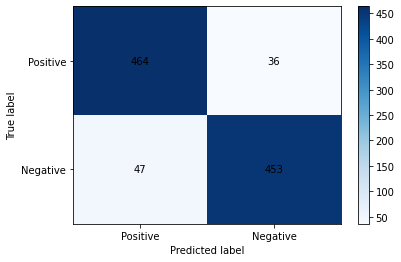

Test loss: 0.012684114552568643 
 Test accuracy: 91.7
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.009356012676325109 
 Training accuracy: 87.52222222222223
Test loss: 0.009680632829666138 
 Test accuracy: 88.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.0041764308038271135 
 Training accuracy: 95.32222222222222
Test loss: 0.008912160811945796 
 Test accuracy: 90.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016521834136607747 
 Training accuracy: 98.31111111111112
Test loss: 0.010661796189844608 
 Test accuracy: 90.2
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008249648073526462 
 Training accuracy: 99.15555555555555
Test loss: 0.012560291551053523 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002643224006929409 

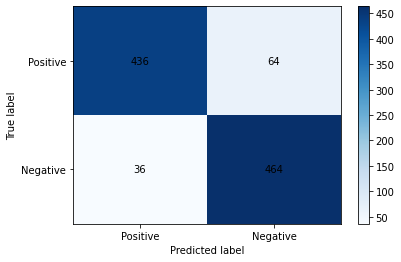

Test loss: 0.015032536391168833 
 Test accuracy: 90.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.009697425074875355 
 Training accuracy: 86.76666666666667
Test loss: 0.007421429842710495 
 Test accuracy: 90.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.004037387665361166 
 Training accuracy: 95.51111111111112
Test loss: 0.008866206275299191 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018694504650257943 
 Training accuracy: 98.04444444444445
Test loss: 0.011219701505731792 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008061008953372948 
 Training accuracy: 99.22222222222223
Test loss: 0.008830204540747217 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 4:
Training los

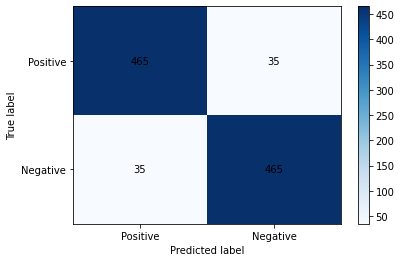

Test loss: 0.013235776393179549 
 Test accuracy: 93.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.00981908163966404 
 Training accuracy: 86.52222222222223
Test loss: 0.010143495984375478 
 Test accuracy: 91.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.003992883898938695 
 Training accuracy: 95.76666666666667
Test loss: 0.006774617876857519 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.001838966497220099 
 Training accuracy: 98.35555555555555
Test loss: 0.008948943845927716 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006914540662773005 
 Training accuracy: 99.35555555555555
Test loss: 0.010814057620009407 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002750633

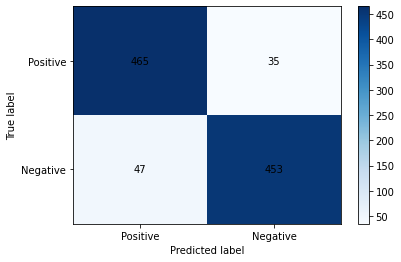

Test loss: 0.013504173884139164 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.009891390915960073 
 Training accuracy: 86.58888888888889
Test loss: 0.006671971209347248 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.003935190225589192 
 Training accuracy: 95.61111111111111
Test loss: 0.007857073238119483 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017326672188678963 
 Training accuracy: 98.35555555555555
Test loss: 0.011385679580271243 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006556968137738295 
 Training accuracy: 99.3888888888889
Test loss: 0.013996667258441448 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 4:
Training loss: 0.00023087215328996535 


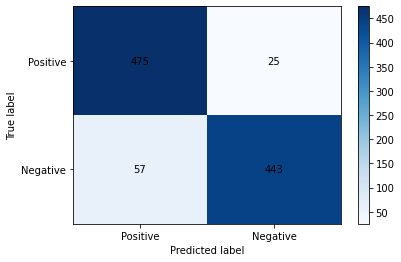

Test loss: 0.015103228386491536 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.009454594114588367 
 Training accuracy: 87.86666666666667
Test loss: 0.011049501851201057 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.004227698721405533 
 Training accuracy: 95.32222222222222
Test loss: 0.007496303396066651 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.00185006583104324 
 Training accuracy: 98.04444444444445
Test loss: 0.011891284335404635 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007315450661181886 
 Training accuracy: 99.4
Test loss: 0.01163043667236343 
 Test accuracy: 90.9
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002721343152152258 
 Tr

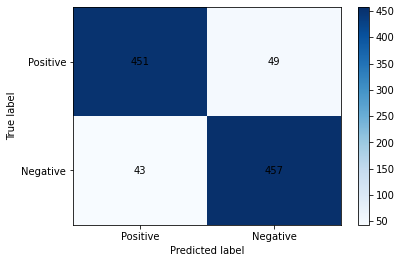

Test loss: 0.015379064015112817 
 Test accuracy: 90.8
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.009615025858291321 
 Training accuracy: 87.43333333333332
Test loss: 0.00790938450396061 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.004184150892620285 
 Training accuracy: 95.5
Test loss: 0.008694269725121558 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.001971477412670437 
 Training accuracy: 97.87777777777778
Test loss: 0.009193006330053322 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008655825837340672 
 Training accuracy: 99.24444444444444
Test loss: 0.010632887438405306 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.0004927914

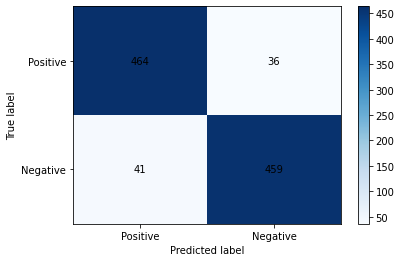

Test loss: 0.014014763792278244 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.00980548937453164 
 Training accuracy: 86.72222222222223
Test loss: 0.009984187558293342 
 Test accuracy: 90.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.004137223637041946 
 Training accuracy: 95.38888888888889
Test loss: 0.009685051795095205 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0018414861443193837 
 Training accuracy: 98.16666666666667
Test loss: 0.010183409526944161 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007298856247475164 
 Training accuracy: 99.28888888888889
Test loss: 0.012998815026134253 
 Test accuracy: 91.60000000000001
------------------------------------------------------------------
epoch 4:


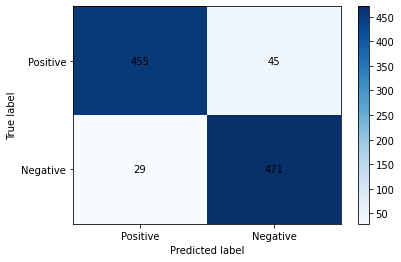

Test loss: 0.012782406793325209 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.009554871573216385 
 Training accuracy: 87.3111111111111
Test loss: 0.0065393755547702315 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.004055297159796788 
 Training accuracy: 95.7
Test loss: 0.0077831006925553085 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.002017522164335888 
 Training accuracy: 97.97777777777777
Test loss: 0.014529538109898568 
 Test accuracy: 86.1
------------------------------------------------------------------
epoch 3:
Training loss: 0.000760868263288608 
 Training accuracy: 99.36666666666667
Test loss: 0.008482718702405691 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.000286691

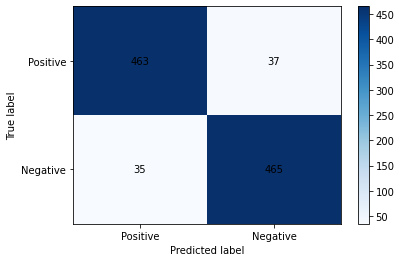

Test loss: 0.00959924511052668 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.00939180700108409 
 Training accuracy: 87.3111111111111
Test loss: 0.010489071302115916 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.003807958917381863 
 Training accuracy: 95.97777777777777
Test loss: 0.014807420849334448 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016920041605933674 
 Training accuracy: 98.28888888888889
Test loss: 0.011785294268280268 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008525588525161665 
 Training accuracy: 99.17777777777778
Test loss: 0.011550518846139312 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.00030790659

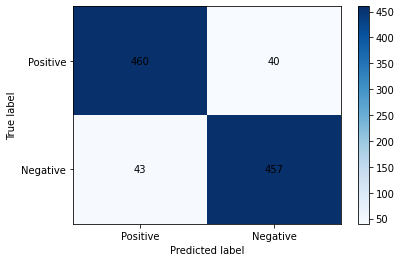

Test loss: 0.013154018515720964 
 Test accuracy: 91.7
------------------------------------------------------------------


In [40]:
mean, std = main_cross_validation(main_LSTM, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

##### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.008802367428938548 
 Training accuracy: 88.42222222222222
Test loss: 0.0075055061876773835 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.003333868261374947 
 Training accuracy: 96.22222222222221
Test loss: 0.006084010936319828 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012435891162668768 
 Training accuracy: 98.77777777777777
Test loss: 0.008175190822221338 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004582766950073468 
 Training accuracy: 99.58888888888889
Test loss: 0.009768642902374268 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00014869656207590904 
 Training accuracy: 99.83333333333333


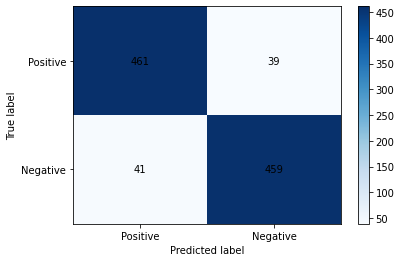

Test loss: 0.013418307516316418 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.008538676042109727 
 Training accuracy: 88.5111111111111
Test loss: 0.008027777291834355 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.0030775822749775318 
 Training accuracy: 96.56666666666666
Test loss: 0.007662549838423729 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0010640308573557477 
 Training accuracy: 98.91111111111111
Test loss: 0.01342464105784893 
 Test accuracy: 90.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.000389954559448395 
 Training accuracy: 99.57777777777778
Test loss: 0.0138033999840045 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 4:
Training loss: 0.000125461937

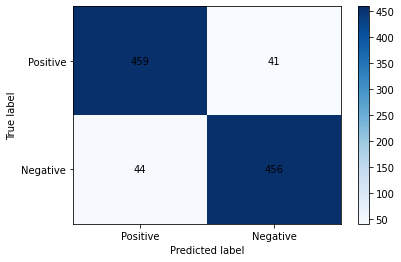

Test loss: 0.017496233246289194 
 Test accuracy: 91.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.008672364588412973 
 Training accuracy: 88.87777777777778
Test loss: 0.006063188575208187 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034427326523905825 
 Training accuracy: 96.17777777777778
Test loss: 0.005412551329471171 
 Test accuracy: 94.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013085866323478208 
 Training accuracy: 98.8
Test loss: 0.007337186393328011 
 Test accuracy: 93.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.00047933402052290655 
 Training accuracy: 99.6111111111111
Test loss: 0.008927332000341267 
 Test accuracy: 93.60000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00014214460961274098

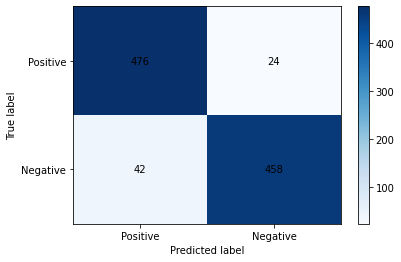

Test loss: 0.011409994679502888 
 Test accuracy: 93.4
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.008619174840963549 
 Training accuracy: 88.62222222222222
Test loss: 0.005325494095683098 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.003365791758832832 
 Training accuracy: 96.44444444444444
Test loss: 0.006062408864498138 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012414987580834551 
 Training accuracy: 98.82222222222222
Test loss: 0.007229445345466956 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00039510087948721977 
 Training accuracy: 99.62222222222222
Test loss: 0.010483257310464978 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.0001325

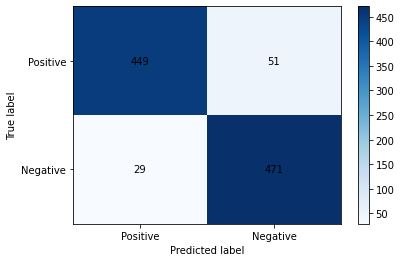

Test loss: 0.013185927122831344 
 Test accuracy: 92.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.008994941716392835 
 Training accuracy: 88.06666666666668
Test loss: 0.00663744031637907 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.0032935739586213864 
 Training accuracy: 96.28888888888889
Test loss: 0.0078876497996971 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 2:
Training loss: 0.001236426044485092 
 Training accuracy: 98.85555555555555
Test loss: 0.00838380734436214 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004130754133243247 
 Training accuracy: 99.66666666666667
Test loss: 0.011186827018857003 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.000103315938

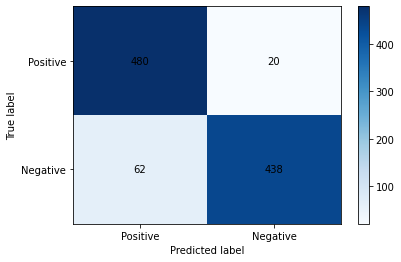

Test loss: 0.015687697763075447 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.008633994239899847 
 Training accuracy: 88.56666666666668
Test loss: 0.006917690843343735 
 Test accuracy: 91.3
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033813508314843705 
 Training accuracy: 96.17777777777778
Test loss: 0.006545676169916987 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.001126472348418449 
 Training accuracy: 98.96666666666667
Test loss: 0.009956859264522791 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004135843406830746 
 Training accuracy: 99.67777777777778
Test loss: 0.01293187460768968 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 4:
Training loss

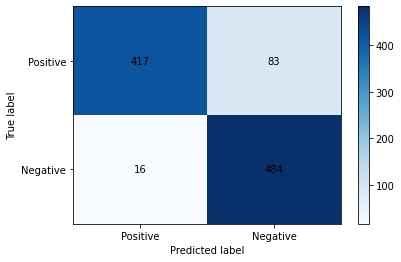

Test loss: 0.025460841855499895 
 Test accuracy: 90.10000000000001
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.008821483861654997 
 Training accuracy: 88.76666666666667
Test loss: 0.0061596640311181545 
 Test accuracy: 93.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.003631575861790528 
 Training accuracy: 95.96666666666667
Test loss: 0.006695008686743676 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.001404167135543604 
 Training accuracy: 98.57777777777777
Test loss: 0.007550656288862229 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004728560788134928 
 Training accuracy: 99.55555555555556
Test loss: 0.01213084335438907 
 Test accuracy: 92.80000000000001
---------------------------------------------------------------

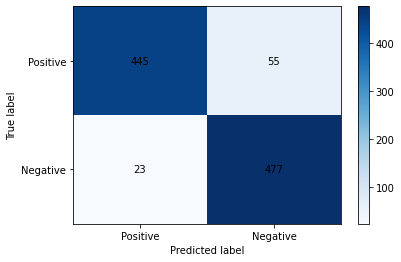

Test loss: 0.015540857552550733 
 Test accuracy: 92.2
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.008759645409054226 
 Training accuracy: 88.75555555555556
Test loss: 0.0058251902461051944 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034605075878401596 
 Training accuracy: 96.13333333333334
Test loss: 0.008450525984168053 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012898809431547609 
 Training accuracy: 98.73333333333333
Test loss: 0.00641120684472844 
 Test accuracy: 93.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005263252550915543 
 Training accuracy: 99.52222222222223
Test loss: 0.008121000287635979 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0001264

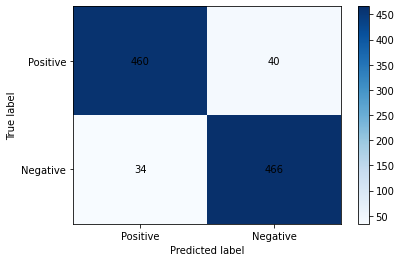

Test loss: 0.012338295495603233 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.00849147070861525 
 Training accuracy: 88.63333333333333
Test loss: 0.006552266713231802 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.003472832849352724 
 Training accuracy: 96.21111111111111
Test loss: 0.005998503480106592 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013130164958808262 
 Training accuracy: 98.7
Test loss: 0.008402436951640993 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004985794102608958 
 Training accuracy: 99.54444444444445
Test loss: 0.00910978675633669 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss:

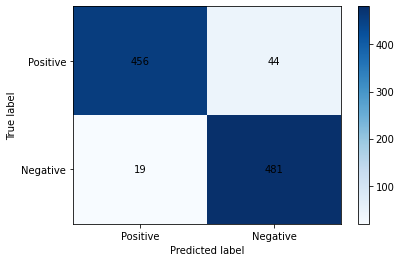

Test loss: 0.01132670020882506 
 Test accuracy: 93.7
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.008800169735215604 
 Training accuracy: 87.66666666666667
Test loss: 0.007065187204629183 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033755926942556267 
 Training accuracy: 96.25555555555556
Test loss: 0.006592713691294193 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.001376710307040614 
 Training accuracy: 98.67777777777778
Test loss: 0.007580097045749426 
 Test accuracy: 93.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.00046235093710452526 
 Training accuracy: 99.63333333333333
Test loss: 0.008874986714188708 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 4:
Training loss: 0.00019081120288380287 

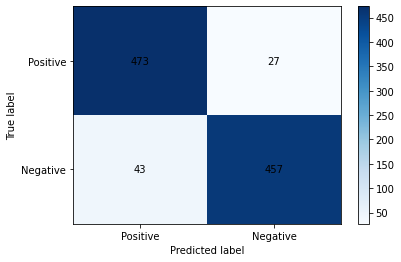

Test loss: 0.013093790002327296 
 Test accuracy: 93.0
------------------------------------------------------------------


In [41]:
mean, std = main_cross_validation(main, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### Deep Models (GloVe embedding)
##### BiLSTM


 Fold: 0
epoch 0:
Training loss: 0.009925067821310626 
 Training accuracy: 86.9
Test loss: 0.016378203883767126 
 Test accuracy: 82.69999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.004401286036914421 
 Training accuracy: 95.15555555555557
Test loss: 0.010015353843569755 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017171313656985552 
 Training accuracy: 98.23333333333333
Test loss: 0.014710191916674376 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007389690394112323 
 Training accuracy: 99.3888888888889
Test loss: 0.017293673999607562 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.00028250534030181977 
 Training accuracy: 99.73333333333333


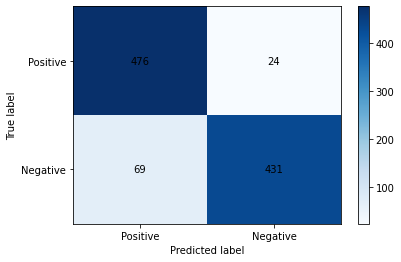

Test loss: 0.014637907579541207 
 Test accuracy: 90.7
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.009316743727359507 
 Training accuracy: 87.67777777777778
Test loss: 0.012323508828878402 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.0038480351460683676 
 Training accuracy: 95.77777777777777
Test loss: 0.009777692176401615 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016384590110845036 
 Training accuracy: 98.37777777777778
Test loss: 0.014010774137452244 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007227974518545023 
 Training accuracy: 99.33333333333333
Test loss: 0.013606656727846712 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002906

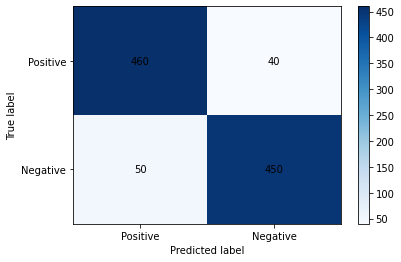

Test loss: 0.015037372373044491 
 Test accuracy: 91.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.00950173852675491 
 Training accuracy: 87.03333333333333
Test loss: 0.009011966712772846 
 Test accuracy: 89.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.004095116584251325 
 Training accuracy: 95.46666666666667
Test loss: 0.006762823693454266 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016528044675554459 
 Training accuracy: 98.12222222222222
Test loss: 0.011355033124797046 
 Test accuracy: 92.2
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007287680742188564 
 Training accuracy: 99.24444444444444
Test loss: 0.010006573638878762 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.000270305

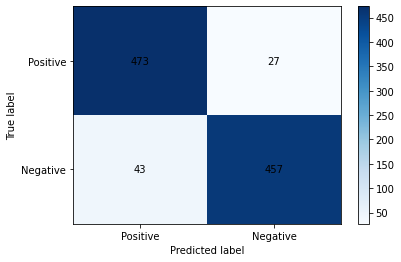

Test loss: 0.011777544662181753 
 Test accuracy: 93.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.009603222649130556 
 Training accuracy: 86.96666666666667
Test loss: 0.007455233603715896 
 Test accuracy: 90.4
------------------------------------------------------------------
epoch 1:
Training loss: 0.004014998479228881 
 Training accuracy: 95.7
Test loss: 0.006329124175012112 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0019717144900415506 
 Training accuracy: 98.02222222222223
Test loss: 0.008539181880652905 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 3:
Training loss: 0.000737506193506609 
 Training accuracy: 99.27777777777777
Test loss: 0.01151774627517443 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002880516039181708 
 Training accur

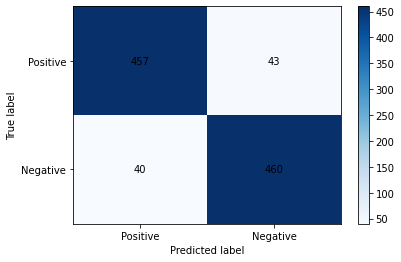

Test loss: 0.013365984436124563 
 Test accuracy: 91.7
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.009678348223368327 
 Training accuracy: 87.06666666666666
Test loss: 0.008656957753002643 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.004026713809515867 
 Training accuracy: 95.92222222222222
Test loss: 0.00635513549298048 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0019537331892125723 
 Training accuracy: 97.9888888888889
Test loss: 0.008114456109702586 
 Test accuracy: 91.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007325236911419779 
 Training accuracy: 99.27777777777777
Test loss: 0.012905988391488791 
 Test accuracy: 90.9
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002424759

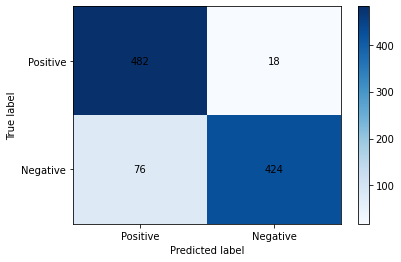

Test loss: 0.015287590324878692 
 Test accuracy: 90.60000000000001
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.00968989090455903 
 Training accuracy: 87.16666666666667
Test loss: 0.00817975640296936 
 Test accuracy: 89.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.0038439119281247257 
 Training accuracy: 95.76666666666667
Test loss: 0.007662172790616751 
 Test accuracy: 91.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.001667572076859263 
 Training accuracy: 98.28888888888889
Test loss: 0.012341567449271678 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0006798294449205666 
 Training accuracy: 99.35555555555555
Test loss: 0.011420989656355232 
 Test accuracy: 91.4
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002065352

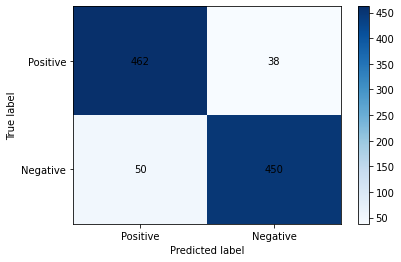

Test loss: 0.014208561113569886 
 Test accuracy: 91.2
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.009763368110689853 
 Training accuracy: 86.72222222222223
Test loss: 0.007799003323540091 
 Test accuracy: 89.60000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.004121839373786416 
 Training accuracy: 95.54444444444444
Test loss: 0.007640286548994481 
 Test accuracy: 90.8
------------------------------------------------------------------
epoch 2:
Training loss: 0.0016098124206505922 
 Training accuracy: 98.42222222222222
Test loss: 0.00802783255954273 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005450550601558967 
 Training accuracy: 99.47777777777777
Test loss: 0.011122371162520722 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 4:
Training loss

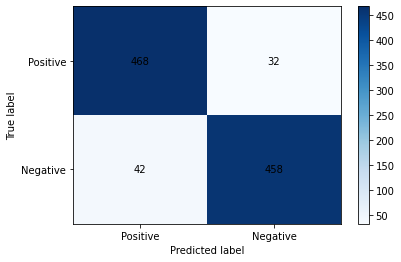

Test loss: 0.013972897912608459 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.009731764991664223 
 Training accuracy: 87.25555555555556
Test loss: 0.008451899912208318 
 Test accuracy: 90.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.004067524100343387 
 Training accuracy: 95.72222222222221
Test loss: 0.010383059509098529 
 Test accuracy: 89.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.001989664851972419 
 Training accuracy: 97.96666666666667
Test loss: 0.01033176302537322 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 3:
Training loss: 0.0008197030304872896 
 Training accuracy: 99.24444444444444
Test loss: 0.013133532302919776 
 Test accuracy: 90.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0002963762

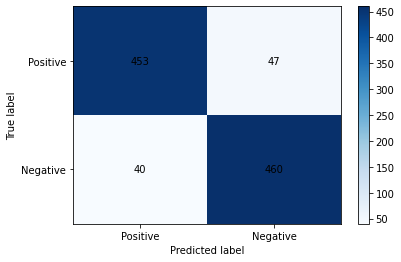

Test loss: 0.01553418535576202 
 Test accuracy: 91.3
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.009409856454365784 
 Training accuracy: 87.37777777777778
Test loss: 0.010046269990503788 
 Test accuracy: 86.2
------------------------------------------------------------------
epoch 1:
Training loss: 0.004053354939963254 
 Training accuracy: 96.13333333333334
Test loss: 0.007438552847132087 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.002102468080818653 
 Training accuracy: 97.93333333333332
Test loss: 0.007639462539926171 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 3:
Training loss: 0.0009143651804123591 
 Training accuracy: 99.23333333333333
Test loss: 0.008906667383387685 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss: 0.0004072676200384093 
 T

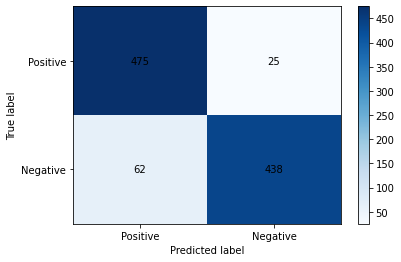

Test loss: 0.013637693686003332 
 Test accuracy: 91.3
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.0094901895850069 
 Training accuracy: 87.73333333333333
Test loss: 0.009051299963146449 
 Test accuracy: 90.7
------------------------------------------------------------------
epoch 1:
Training loss: 0.00421691377978358 
 Training accuracy: 95.38888888888889
Test loss: 0.009146463911980391 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.0017695148782028505 
 Training accuracy: 98.2
Test loss: 0.009999340480193495 
 Test accuracy: 92.7
------------------------------------------------------------------
epoch 3:
Training loss: 0.0007144839232884503 
 Training accuracy: 99.46666666666667
Test loss: 0.01127096178382635 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.00029608840258960197 
 Tr

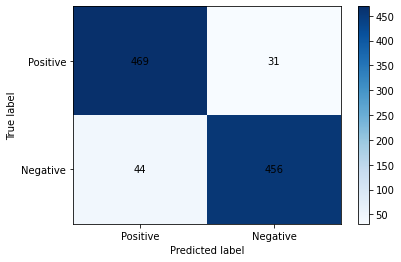

Test loss: 0.012769540339766535 
 Test accuracy: 92.5
------------------------------------------------------------------


In [42]:
subj_embedding_matrix = subj_corpus.get_embedding_matrix(global_vectors, 300)
mean, std = main_cross_validation(main_LSTM, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

##### BiLSTM with attention


 Fold: 0
epoch 0:
Training loss: 0.008572679167820348 
 Training accuracy: 88.8
Test loss: 0.0064564530458301305 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.0032163347948290823 
 Training accuracy: 96.32222222222222
Test loss: 0.00602882519364357 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0011126603686328358 
 Training accuracy: 98.97777777777777
Test loss: 0.011219847439322621 
 Test accuracy: 92.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.00042678174942718924 
 Training accuracy: 99.55555555555556
Test loss: 0.012089146098122 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 4:
Training loss: 0.00016098579294753613 
 Training accuracy: 99.83333333333333


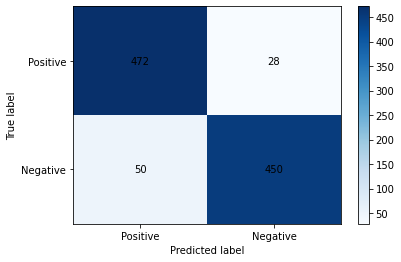

Test loss: 0.01887508799508214 
 Test accuracy: 92.2
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.008773636131650872 
 Training accuracy: 88.67777777777778
Test loss: 0.007319900669157505 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0034356002277798124 
 Training accuracy: 96.22222222222221
Test loss: 0.007683468138799071 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012205627744972137 
 Training accuracy: 98.77777777777777
Test loss: 0.008483022230677307 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005158761976199458 
 Training accuracy: 99.41111111111111
Test loss: 0.00984184816479683 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.000167382

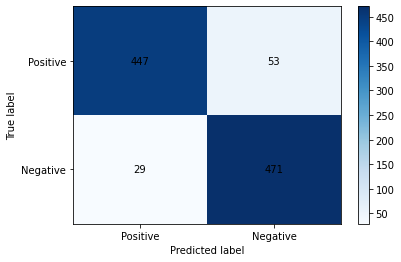

Test loss: 0.014046553907741326 
 Test accuracy: 91.8
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.008550815953562657 
 Training accuracy: 88.9
Test loss: 0.006005456795915961 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0032608885038644076 
 Training accuracy: 96.44444444444444
Test loss: 0.0059974917508661746 
 Test accuracy: 94.3
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012011226955833587 
 Training accuracy: 98.96666666666667
Test loss: 0.00658997617661953 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 3:
Training loss: 0.00045289288178416125 
 Training accuracy: 99.58888888888889
Test loss: 0.010171546606346964 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 4:
Training loss: 0.000171

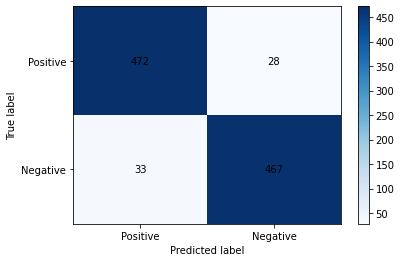

Test loss: 0.011837291254661977 
 Test accuracy: 93.89999999999999
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.00924580790495707 
 Training accuracy: 87.43333333333332
Test loss: 0.005972161777317524 
 Test accuracy: 93.89999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033810829994165236 
 Training accuracy: 96.46666666666667
Test loss: 0.006716587039642036 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013048894995137945 
 Training accuracy: 98.72222222222223
Test loss: 0.006161472015082836 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0005150607938024526 
 Training accuracy: 99.56666666666666
Test loss: 0.008706175026018172 
 Test accuracy: 93.10000000000001
--------------------------------------------------------------

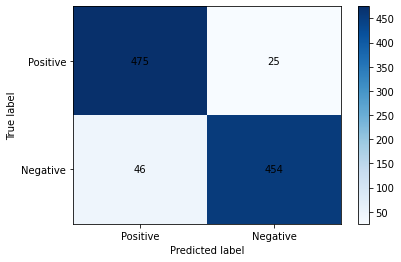

Test loss: 0.010069209713488817 
 Test accuracy: 92.9
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.008343932334333658 
 Training accuracy: 88.82222222222222
Test loss: 0.00563727262057364 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.0031881158109754323 
 Training accuracy: 96.51111111111112
Test loss: 0.005785432155709713 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0011316448455262515 
 Training accuracy: 98.88888888888889
Test loss: 0.008323973258025944 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0003259842575866464 
 Training accuracy: 99.73333333333333
Test loss: 0.015520827940665186 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 4:
Training los

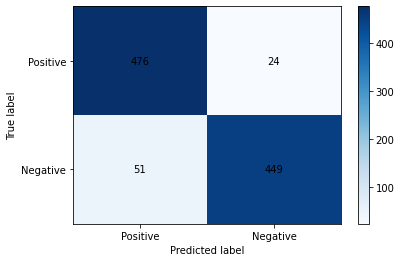

Test loss: 0.016643376454874216 
 Test accuracy: 92.5
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.008386582903977898 
 Training accuracy: 89.33333333333333
Test loss: 0.006534988395869732 
 Test accuracy: 91.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.003307079559502502 
 Training accuracy: 96.1888888888889
Test loss: 0.006021463986486197 
 Test accuracy: 92.80000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.001166705793717281 
 Training accuracy: 98.87777777777778
Test loss: 0.0085219518635422 
 Test accuracy: 93.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.00033870928702597463 
 Training accuracy: 99.7
Test loss: 0.013524027102612309 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 4:
Training loss: 8.056667517036568e-05 
 Tr

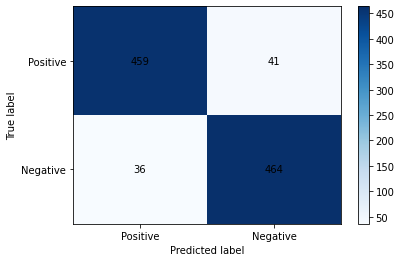

Test loss: 0.015997073869606537 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.00866240605401496 
 Training accuracy: 88.77777777777777
Test loss: 0.006434267610311508 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 1:
Training loss: 0.0033437398816717583 
 Training accuracy: 96.24444444444444
Test loss: 0.006501935411244631 
 Test accuracy: 92.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012578455277317618 
 Training accuracy: 98.6888888888889
Test loss: 0.007856472663581372 
 Test accuracy: 92.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004107053382601104 
 Training accuracy: 99.52222222222223
Test loss: 0.011865137091604992 
 Test accuracy: 91.7
------------------------------------------------------------------
epoch 4:
Training loss

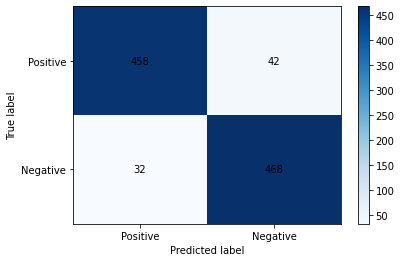

Test loss: 0.014086227437510389 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------

 Fold: 7
epoch 0:
Test loss: 0.005549572279676795 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 1:
Training loss: 0.003274853467837804 
 Training accuracy: 96.53333333333333
Test loss: 0.006093086283653975 
 Test accuracy: 92.60000000000001
------------------------------------------------------------------
epoch 2:
Training loss: 0.0012448395588047182 
 Training accuracy: 98.74444444444444
Test loss: 0.007000251784455031 
 Test accuracy: 92.30000000000001
------------------------------------------------------------------
epoch 3:
Training loss: 0.0003938310236066892 
 Training accuracy: 99.64444444444445
Test loss: 0.012818603254854679 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 4:
Training loss: 9.509825531090933e-05 
 Training accuracy: 99.9222222222222

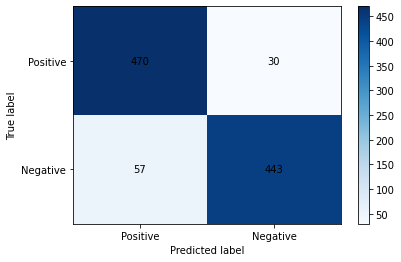

Test loss: 0.01672692110016942 
 Test accuracy: 91.3
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.008524543219970333 
 Training accuracy: 88.95555555555555
Test loss: 0.006131256490014493 
 Test accuracy: 93.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.003085025414177734 
 Training accuracy: 96.42222222222222
Test loss: 0.006804598642047494 
 Test accuracy: 93.4
------------------------------------------------------------------
epoch 2:
Training loss: 0.0010606843535513487 
 Training accuracy: 98.85555555555555
Test loss: 0.011124664820730686 
 Test accuracy: 90.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.0004096778550681645 
 Training accuracy: 99.62222222222222
Test loss: 0.009837385234306566 
 Test accuracy: 92.9
------------------------------------------------------------------
epoch 4:
Training loss: 0.00011893844779004009 


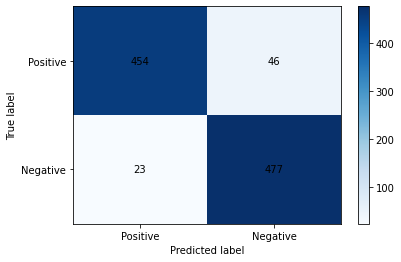

Test loss: 0.01269828984630294 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.008684267403350937 
 Training accuracy: 88.25555555555556
Test loss: 0.0067807961627841 
 Test accuracy: 91.8
------------------------------------------------------------------
epoch 1:
Training loss: 0.0032441229961502056 
 Training accuracy: 96.56666666666666
Test loss: 0.00677745542768389 
 Test accuracy: 93.2
------------------------------------------------------------------
epoch 2:
Training loss: 0.0013856925028829007 
 Training accuracy: 98.64444444444445
Test loss: 0.007653711635590298 
 Test accuracy: 92.4
------------------------------------------------------------------
epoch 3:
Training loss: 0.000530909231259203 
 Training accuracy: 99.5111111111111
Test loss: 0.0095837900218321 
 Test accuracy: 93.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.000178651296152

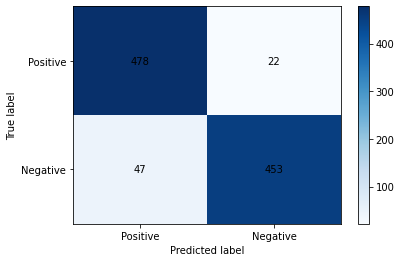

Test loss: 0.013986893606532248 
 Test accuracy: 93.10000000000001
------------------------------------------------------------------


In [43]:
mean, std = main_cross_validation(main, subj_dataset, subj_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

## Polarity Tests
### Shallow baseline

In [44]:
# Taking the best estimator in accuracy from Subjectivity detection with Naive Bayes
pred = scores["estimator"][scores["test_accuracy"].argmax()]

In [45]:
def remove_objective_sents(vectorizer, estimator, corpus):
  transformed_corpus = [[vectorizer.transform([neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
  res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if estimator.predict(sent).item()]
          for doc_idx, doc in enumerate(transformed_corpus)]
  return res

In [46]:
def neg_marking_subj(doc):
  # takes the doc and produces a single list
  flattened_doc = [w for sent in doc for w in sent]
  # negates the whole document
  negated_doc = mark_negation(flattened_doc, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [47]:
mr = movie_reviews
neg = mr.paras(categories = "neg")
pos = mr.paras(categories = "pos")
mr_corpus = pos + neg


mr_corpus = remove_objective_sents(vectorizer, pred, mr_corpus)
mr_corpus = [neg_marking_subj(d) for d in mr_corpus]

In [48]:
vectors = vectorizer.fit_transform(mr_corpus)
labels = np.array([0] * len(pos) + [1] * len(neg))

# Redefine vectorizer and classifier since already used for subjectivity
# classifier = SVC(kernel = "linear")

In [49]:
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
print(round(average, 3))

0.863


### Deep Models (FastText Emebdding)
In this section I am going to analyze perfomances of deep models using fast-text embedding

#### BiLSTM

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### BiLSTM with attention mechanism


 Fold: 0
epoch 0:
Training loss: 0.02128749516275194 
 Training accuracy: 59.333333333333336
Test loss: 0.02139965444803238 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.018284370137585534 
 Training accuracy: 75.72222222222223
Test loss: 0.02205782860517502 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.012609743482122819 
 Training accuracy: 82.27777777777779
Test loss: 0.01492771178483963 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.007431173055536217 
 Training accuracy: 90.94444444444446
Test loss: 0.013917664736509324 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.004434821984937621 
 Training accuracy: 95.05555555555556
Test loss: 0.012671970576047898 
 Test accuracy: 88.0
-----------------------------------

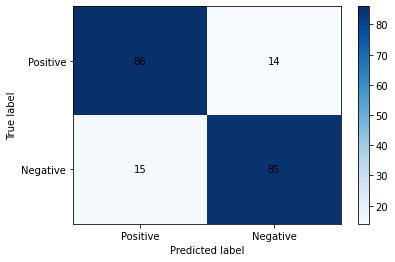

Test loss: 0.02086895003914833 
 Test accuracy: 85.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.021741503443982867 
 Training accuracy: 55.111111111111114
Test loss: 0.023388731479644775 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01715947030319108 
 Training accuracy: 72.77777777777777
Test loss: 0.027318781316280363 
 Test accuracy: 63.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.01059255591697163 
 Training accuracy: 86.05555555555556
Test loss: 0.013548598363995553 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.003300387139639093 
 Training accuracy: 96.66666666666667
Test loss: 0.021713900715112686 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.001372021936

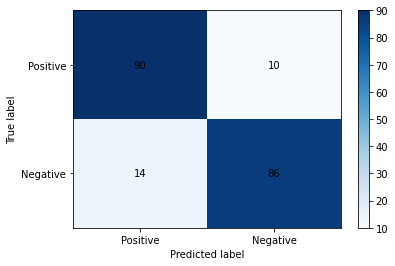

Test loss: 0.028912326007557568 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.021896994213263195 
 Training accuracy: 52.166666666666664
Test loss: 0.023483474254608155 
 Test accuracy: 64.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.017911584509743585 
 Training accuracy: 72.94444444444444
Test loss: 0.023157893866300582 
 Test accuracy: 68.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010361310876905918 
 Training accuracy: 86.27777777777777
Test loss: 0.02437053292989731 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.00523920215252373 
 Training accuracy: 93.88888888888889
Test loss: 0.027162908315658568 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00282244277639418 
 Trai

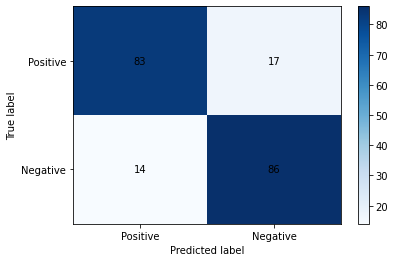

Test loss: 0.040137484669685364 
 Test accuracy: 84.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.02147288186682595 
 Training accuracy: 55.44444444444444
Test loss: 0.020720783174037933 
 Test accuracy: 65.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016282136771414015 
 Training accuracy: 75.55555555555556
Test loss: 0.0167427895963192 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008869739816420608 
 Training accuracy: 88.33333333333333
Test loss: 0.018607031106948852 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004580652931601637 
 Training accuracy: 95.33333333333334
Test loss: 0.01342482041567564 
 Test accuracy: 86.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0034756991050542436 
 Train

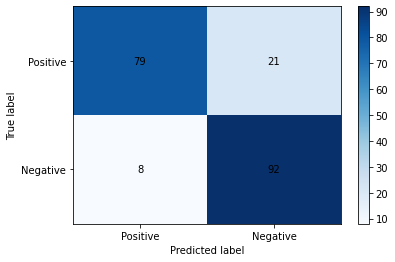

Test loss: 0.03189995812252164 
 Test accuracy: 85.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.021563552882936265 
 Training accuracy: 58.5
Test loss: 0.022176551222801207 
 Test accuracy: 64.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015847010844283634 
 Training accuracy: 77.16666666666666
Test loss: 0.015164721757173538 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.011077520694169733 
 Training accuracy: 86.0
Test loss: 0.02120656132698059 
 Test accuracy: 74.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0055612277762136526 
 Training accuracy: 93.88888888888889
Test loss: 0.01630653567612171 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0019656301874460447 
 Training accuracy: 98.1111111

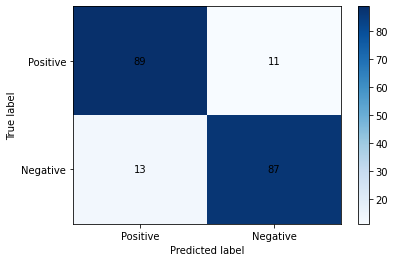

Test loss: 0.027874404962640254 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.021687823335329693 
 Training accuracy: 54.888888888888886
Test loss: 0.020913019478321075 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.018965718961424297 
 Training accuracy: 74.44444444444444
Test loss: 0.017283175140619278 
 Test accuracy: 77.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.01095610487792227 
 Training accuracy: 85.22222222222223
Test loss: 0.012043324261903764 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004687718044862979 
 Training accuracy: 94.33333333333334
Test loss: 0.016938131079077722 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0021031005181268683 
 T

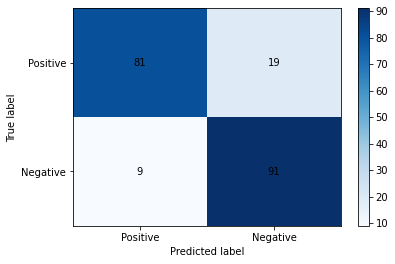

Test loss: 0.02539395824046551 
 Test accuracy: 86.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.02174828890297148 
 Training accuracy: 54.833333333333336
Test loss: 0.022972553968429565 
 Test accuracy: 66.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01774476557970047 
 Training accuracy: 70.44444444444444
Test loss: 0.01655178889632225 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.009253338558806314 
 Training accuracy: 88.38888888888889
Test loss: 0.020900078266859055 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004354616872345408 
 Training accuracy: 95.5
Test loss: 0.017781957983970642 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0016329185868703968 
 Training accuracy

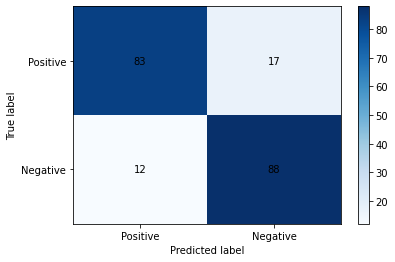

Test loss: 0.02651584878563881 
 Test accuracy: 85.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.020986992518107095 
 Training accuracy: 57.611111111111114
Test loss: 0.023729488402605057 
 Test accuracy: 69.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015251485001709726 
 Training accuracy: 78.16666666666666
Test loss: 0.025795094221830368 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008198243495490816 
 Training accuracy: 89.72222222222223
Test loss: 0.01594538077712059 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0036292146436042254 
 Training accuracy: 96.22222222222221
Test loss: 0.019519390761852263 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0024984373757615686 
 T

KeyboardInterrupt: ignored

In [51]:
# Smaller batch sizes are noisy, this means that they are more regularizing and the
# generalization error will be lower
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
# 85.6 +- 3.6 using 32 as bsize
# 85.3 +- 3.01
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### Removing objective sentences:
Now the the BiLSTM and BiLSTM with attention will be tested again, but the corpus will have the objective sentences removed.

In [ ]:
# -1 adds the element in the penultimate position (Since flattener should be the last one)
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 5, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
# 87.95 +- 1.54
# 87.3 +- 0.84
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### LBSA

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
# 86.2 +- 2.21
# 86.1 +- 3
# 86.45 +- 2.65
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

Remove Objective sentences

In [ ]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
# - mean: 88.5 
# - standard deviation: 1.9235384061671346

# 88.7 +- 1.73
# Good Run:
# - mean: 89.35 
# - standard deviation: 1.285496013218244

# Run mapping al Senticnet and sentiwordnet to [0,1]:

print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

### Deep Models (Glove 840B Embedding)

#### BiLSTM and BiLSTM with attention

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### LBSA

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

## Result analysis:

Train a netwrok from scratch

In [36]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner(),
                       ShallowObjectiveSentsRemover(pred)
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

epoch 0:
Training loss: 0.020769996512681247 
 Training accuracy: 57.1875
Test loss: 0.017563230469822885 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013863604804500938 
 Training accuracy: 79.375
Test loss: 0.012184925265610219 
 Test accuracy: 83.75
------------------------------------------------------------------
epoch 2:
Training loss: 0.006970644993707538 
 Training accuracy: 92.5
Test loss: 0.009749482292681933 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0026464064231549855 
 Training accuracy: 97.0
Test loss: 0.011297157686203717 
 Test accuracy: 88.75
------------------------------------------------------------------
epoch 4:
Training loss: 0.0013745975535493927 
 Training accuracy: 98.5625
Test loss: 0.012979472130537033 
 Test accuracy: 90.75
------------------------------------------------------------------
epoch 5:
Training loss: 0.0

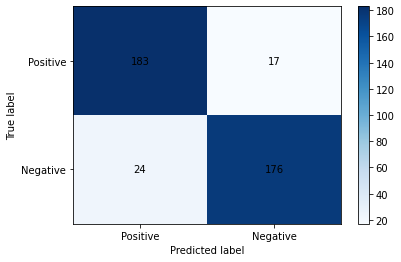

Test loss: 0.025215624179691077 
 Test accuracy: 89.75
------------------------------------------------------------------


In [37]:
if torch.cuda.is_available():
  device = 'cuda'
train_indexes = [i*1000 + j for i in range(2) for j in range(800)]
test_indexes = [i*1000 + j for i in range(2) for j in range(800,1000)]


train_sampler = SubsetRandomSampler(train_indexes)
test_sampler = SubsetRandomSampler(test_indexes)

train_loader = DataLoader(mr_dataset, batch_size = 32, sampler = train_sampler,
                          collate_fn = collate, pin_memory=True)
test_loader = DataLoader(mr_dataset, batch_size = 32, sampler = test_sampler,
                        collate_fn = collate, pin_memory = True)

# Important that we keep a trained network
net = BiLSTMAttention(mr_embedding_matrix)
test_accuracy = main(train_loader, test_loader, mr_embedding_matrix, device, 10, net)

In [38]:
def indexed_corpus(corpus, vocab):
  # I don't care about labels since I'm not backpropagating and I am only interested in attention map
  labels = [1 for i in range(len(corpus))]
  new_vocab = {}
  for idx, key in enumerate(vocab.keys()):
    new_vocab[key] = idx

  indexed_corpus = [torch.tensor([torch.tensor(new_vocab[w], dtype=torch.int32) for w in doc]) for doc in corpus]
  return corpus, indexed_corpus, labels

In [80]:
for idxdoc, doc in enumerate(pos):
  for idxsent, sent in enumerate(doc):
    for word in sent:
      if word == "beautiful":
        print(f"doc: {idxdoc} \n sent: {idxsent}")

doc: 3 
 sent: 4
doc: 28 
 sent: 11
doc: 33 
 sent: 19
doc: 33 
 sent: 22
doc: 35 
 sent: 19
doc: 53 
 sent: 6
doc: 60 
 sent: 36
doc: 66 
 sent: 0
doc: 78 
 sent: 1
doc: 83 
 sent: 19
doc: 83 
 sent: 22
doc: 86 
 sent: 33
doc: 87 
 sent: 39
doc: 87 
 sent: 40
doc: 94 
 sent: 23
doc: 95 
 sent: 0
doc: 95 
 sent: 7
doc: 95 
 sent: 15
doc: 95 
 sent: 23
doc: 95 
 sent: 27
doc: 113 
 sent: 25
doc: 129 
 sent: 1
doc: 129 
 sent: 3
doc: 129 
 sent: 12
doc: 129 
 sent: 16
doc: 133 
 sent: 1
doc: 133 
 sent: 12
doc: 143 
 sent: 7
doc: 144 
 sent: 0
doc: 160 
 sent: 26
doc: 163 
 sent: 27
doc: 167 
 sent: 2
doc: 167 
 sent: 17
doc: 167 
 sent: 37
doc: 169 
 sent: 17
doc: 169 
 sent: 27
doc: 169 
 sent: 52
doc: 171 
 sent: 23
doc: 204 
 sent: 8
doc: 228 
 sent: 23
doc: 237 
 sent: 9
doc: 245 
 sent: 2
doc: 247 
 sent: 26
doc: 248 
 sent: 29
doc: 258 
 sent: 19
doc: 263 
 sent: 2
doc: 264 
 sent: 6
doc: 264 
 sent: 25
doc: 269 
 sent: 36
doc: 275 
 sent: 8
doc: 283 
 sent: 11
doc: 301 
 sent: 23

In [88]:
# I can get training instances just to see attention map
# reduced = mr_corpus.get_subset_indexed_corpus([0, 1000])
some_sentences = mr_pipeline([pos[3]])
some_sentences = some_sentences[0][:5]
reduced = indexed_corpus(some_sentences, mr_corpus.vocab)
reduced_ds = MovieReviewsDataset((reduced[1], reduced[2]))
reduced_dl = DataLoader(reduced_ds, batch_size = 1, collate_fn = collate, pin_memory = True)

In [89]:
net.eval()

with torch.no_grad():
  att = []
  for batch_idx, (inputs, targets, _) in enumerate(reduced_dl):
    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    outputs, attention = net(inputs)
    att.append(attention)

In [90]:
def plot_attention(attention, sentence, filename = None):
  fig, ax = plt.subplots()
  im = ax.imshow(attention.reshape(-1,1).T, cmap='viridis', aspect='auto', origin='lower')
  ax.set_xticks(range(len(sentence)))
  ax.set_xticklabels(sentence, rotation=90)
  cbar = fig.colorbar(im)
  cbar.set_label("Attention Weight")
  ax.set_yticks([])
  ax.set_aspect("equal")
  # plt.savefig(filename)

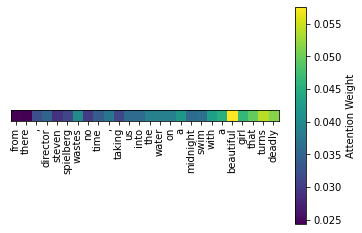

In [102]:
att_arr = att[2][0].cpu().detach().numpy()
plot_attention(att_arr,reduced[0][2])

In [145]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Coverage of the lexicon: 0.3956659944628636


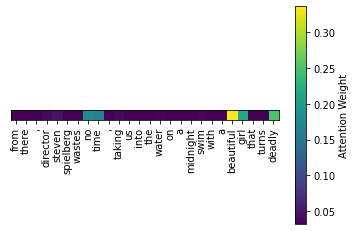

In [146]:
gold_word = LBSA_corpus.wl_gold_av[1003][2]
plot_attention(gold_word,reduced[0][2])

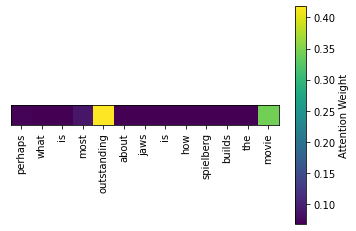

In [147]:
gold_word = LBSA_corpus.wl_gold_av[1003][4]
plot_attention(gold_word,reduced[0][4])